# Portfolio Optimization using Unsupervised Learning K-Means Clustering

This notebook performs **portfolio optimization** using **K-Means clustering**.
The goal is to identify a basket of stocks out of the S&P500 at the beginning of each month as our conservative trading strategy.

## Data Preparation
- Load historical stock prices for last 8 years
- Calculate technical indicators Garman-Klass Volatility, RSI, ATR, Bollinger Bands, and MACD and normalize them.
- Filter out stocks to only keep top 150 most liquid stocks
- Calulate 1 month, 2 month, 3 month, 6 month, 9 month, and 12 month returns.

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas_datareader.data as web
import datetime as dt
import yfinance as yf
from statsmodels.regression.rolling import RollingOLS
import pandas_ta
import warnings
warnings.filterwarnings("ignore")

In [179]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
sp500.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [180]:
sp500["Symbol"] = sp500["Symbol"].str.replace(".", "-")
symbols_list = sp500["Symbol"].unique().tolist()

symbols_list[:10]

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']

In [181]:
end_date = "2024-12-03"
start_date = pd.to_datetime(end_date) - pd.DateOffset(365 * 8) # 8 years before end

In [182]:
df = yf.download(tickers = symbols_list, start = start_date, end = end_date) # download data

df

[*********************100%***********************]  503 of 503 completed


Price            Close                                                  \
Ticker               A        AAPL        ABBV        ABNB         ABT   
Date                                                                     
2016-12-05   41.778671   25.262005   42.762669         NaN   33.078026   
2016-12-06   42.069530   25.456491   43.296669         NaN   33.069424   
2016-12-07   42.210270   25.706537   42.151375         NaN   33.121052   
2016-12-08   42.970203   25.958902   42.790775         NaN   33.293213   
2016-12-09   43.439312   26.382601   43.240459         NaN   33.740791   
...                ...         ...         ...         ...         ...   
2024-11-25  134.241882  232.869995  175.405884  140.929993  117.513321   
2024-11-26  134.122086  235.059998  179.447769  139.669998  117.344215   
2024-11-27  137.885132  234.929993  181.369659  138.279999  118.329041   
2024-11-29  137.715454  237.330002  181.221054  136.110001  118.149979   
2024-12-02  139.322479  239.589996  180.071899  137.490005  116.200218   

Price                                                                  ...  \
Ticker            ACGL         ACN        ADBE         ADI        ADM  ...   
Date                                                                   ...   
2016-12-05   26.609310  104.006989  101.949997   60.544350  34.919598  ...   
2016-12-06   26.764626  104.616615  101.550003   60.887390  35.540028  ...   
2016-12-07   26.904089  107.408485  103.360001   62.551094  35.953663  ...   
2016-12-08   27.338333  107.558685  103.500000   63.357166  36.566154  ...   
2016-12-09   27.319315  108.945816  104.309998   62.722588  37.035458  ...   
...                ...         ...         ...         ...        ...  ...   
2024-11-25  100.059998  361.290009  518.729980  222.637314  53.009998  ...   
2024-11-26  100.410004  363.179993  525.299988  218.126419  53.720001  ...   
2024-11-27  100.739998  362.160004  513.679993  216.254349  54.369999  ...   
2024-11-29  100.720001  362.369995  515.929993  217.130630  54.599998  ...   
2024-12-02   99.300003  361.380005  516.200012  222.179245  54.270000  ...   

Price        Volume                                                          \
Ticker          WTW       WY      WYNN      XEL       XOM      XYL      YUM   
Date                                                                          
2016-12-05   604700  2970600   1678600  1846000  11741100  1212200  2280900   
2016-12-06  1301200  3399000   2892100  2103900  11293600  1474000  2884000   
2016-12-07   928300  5722100   1769500  3076300  11182600  1982000  2655000   
2016-12-08   988500  3008700  12682400  2993700   9086700  1317500  2033800   
2016-12-09   943400  2763800   9967100  2717300   8021700   814100  2395000   
...             ...      ...       ...      ...       ...      ...      ...   
2024-11-25  1118600  7706000   3055000  3122400  26580300  4258900  3604600   
2024-11-26   641600  2365400   1807500  3155900  14827300  1536300  1805700   
2024-11-27  1204700  2785100   1436600  2528400  11079100  1225200  1614100   
2024-11-29   515800  2107900   1402500  1383000   9426500  1084000  1003200   
2024-12-02   816400  3190100   2945200  2718000  12687300  1418300  2295900   

Price                                 
Ticker          ZBH    ZBRA      ZTS  
Date                                  
2016-12-05  1843700  532700  2578200  
2016-12-06  2065253  350900  2573000  
2016-12-07  1605564  465600  4037800  
2016-12-08  1310675  299600  3217000  
2016-12-09  1364338  310200  2664300  
...             ...     ...      ...  
2024-11-25  2028400  420200  4558300  
2024-11-26  1043800  369200  2539600  
2024-11-27  1246000  258300  2315800  
2024-11-29   504100  175700  1543400  
2024-12-02  1508700  294200  2391500  

[2011 rows x 2515 columns]

In [183]:
df = df.stack()
df.head()

Price                  Close       High        Low       Open       Volume
Date       Ticker                                                         
2016-12-05 A       41.778671  41.928785  41.478443  41.478443    2495000.0
           AAPL    25.262005  25.475010  25.062891  25.468065  137298000.0
           ABBV    42.762669  43.015619  41.856262  41.877341   10227700.0
           ABT     33.078026  33.095241  32.699304  32.802591    9514700.0
           ACGL    26.609310  26.612480  26.200424  26.324040    1685400.0

In [184]:
df.to_pickle("sp500_data.pkl")

In [185]:
df = pd.read_pickle("sp500_data.pkl")
df.head()

Price                  Close       High        Low       Open       Volume
Date       Ticker                                                         
2016-12-05 A       41.778671  41.928785  41.478443  41.478443    2495000.0
           AAPL    25.262005  25.475010  25.062891  25.468065  137298000.0
           ABBV    42.762669  43.015619  41.856262  41.877341   10227700.0
           ABT     33.078026  33.095241  32.699304  32.802591    9514700.0
           ACGL    26.609310  26.612480  26.200424  26.324040    1685400.0

In [186]:
df.index.names = ["date", "ticker"]
df.columns = df.columns.str.lower()

In [187]:
# Garman-Klass Volatility. YF gives "adj close" as "close"

df["garman_klass_vol"] = ((np.log(df["high"]) - np.log(df["low"])) ** 2) / 2 - (2 * np.log(2) - 1) * ((np.log(df["close"]) - np.log(df["open"])) ** 2)
df.head()

Price                  close       high        low       open       volume  \
date       ticker                                                            
2016-12-05 A       41.778671  41.928785  41.478443  41.478443    2495000.0   
           AAPL    25.262005  25.475010  25.062891  25.468065  137298000.0   
           ABBV    42.762669  43.015619  41.856262  41.877341   10227700.0   
           ABT     33.078026  33.095241  32.699304  32.802591    9514700.0   
           ACGL    26.609310  26.612480  26.200424  26.324040    1685400.0   

Price              garman_klass_vol  
date       ticker                    
2016-12-05 A               0.000038  
           AAPL            0.000108  
           ABBV            0.000204  
           ABT             0.000045  
           ACGL            0.000077

In [188]:
# RSI

df["rsi"] = df.groupby(level = 1)["close"].transform(lambda x: pandas_ta.rsi(close = x, length = 20))
df

Price                   close        high         low        open  \
date       ticker                                                   
2016-12-05 A        41.778671   41.928785   41.478443   41.478443   
           AAPL     25.262005   25.475010   25.062891   25.468065   
           ABBV     42.762669   43.015619   41.856262   41.877341   
           ABT      33.078026   33.095241   32.699304   32.802591   
           ACGL     26.609310   26.612480   26.200424   26.324040   
...                       ...         ...         ...         ...   
2024-12-02 XYL     127.010002  127.250000  125.180000  126.699997   
           YUM     139.029999  139.410004  137.339996  137.929993   
           ZBH     110.251846  111.359354  109.982456  111.159806   
           ZBRA    410.040009  412.459991  406.600006  409.290009   
           ZTS     176.277084  176.376789  173.206366  175.250190   

Price                   volume  garman_klass_vol        rsi  
date       ticker                                            
2016-12-05 A         2495000.0          0.000038        NaN  
           AAPL    137298000.0          0.000108        NaN  
           ABBV     10227700.0          0.000204        NaN  
           ABT       9514700.0          0.000045        NaN  
           ACGL      1685400.0          0.000077        NaN  
...                        ...               ...        ...  
2024-12-02 XYL       1418300.0          0.000132  50.154186  
           YUM       2295900.0          0.000088  60.283349  
           ZBH       1508700.0          0.000051  53.822086  
           ZBRA       294200.0          0.000101  66.690356  
           ZTS       2391500.0          0.000151  45.696783  

[991339 rows x 7 columns]

In [189]:
# Normalize rsi

df["rsi"] = df.groupby(level=1)["rsi"].transform(lambda x: (x - x.mean()) / x.std())
df

Price                   close        high         low        open  \
date       ticker                                                   
2016-12-05 A        41.778671   41.928785   41.478443   41.478443   
           AAPL     25.262005   25.475010   25.062891   25.468065   
           ABBV     42.762669   43.015619   41.856262   41.877341   
           ABT      33.078026   33.095241   32.699304   32.802591   
           ACGL     26.609310   26.612480   26.200424   26.324040   
...                       ...         ...         ...         ...   
2024-12-02 XYL     127.010002  127.250000  125.180000  126.699997   
           YUM     139.029999  139.410004  137.339996  137.929993   
           ZBH     110.251846  111.359354  109.982456  111.159806   
           ZBRA    410.040009  412.459991  406.600006  409.290009   
           ZTS     176.277084  176.376789  173.206366  175.250190   

Price                   volume  garman_klass_vol       rsi  
date       ticker                                           
2016-12-05 A         2495000.0          0.000038       NaN  
           AAPL    137298000.0          0.000108       NaN  
           ABBV     10227700.0          0.000204       NaN  
           ABT       9514700.0          0.000045       NaN  
           ACGL      1685400.0          0.000077       NaN  
...                        ...               ...       ...  
2024-12-02 XYL       1418300.0          0.000132 -0.307451  
           YUM       2295900.0          0.000088  0.664397  
           ZBH       1508700.0          0.000051  0.242215  
           ZBRA       294200.0          0.000101  1.314177  
           ZTS       2391500.0          0.000151 -0.853863  

[991339 rows x 7 columns]

<Axes: xlabel='date'>

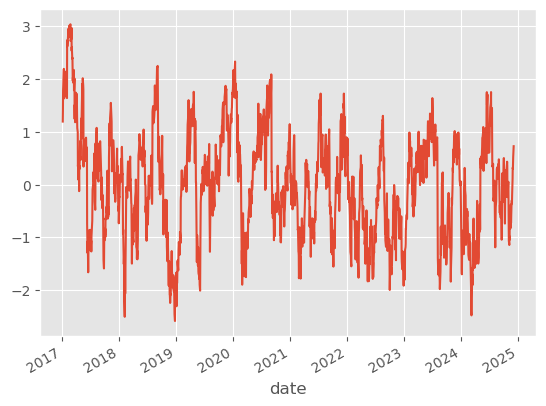

In [190]:
df.xs("AAPL", level = 1)["rsi"].plot()

In [191]:
# Bollinger Bands - lower, middle, and upper

df["bb_low"] = df.groupby(level = 1)["close"].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 0])

df["bb_mid"] = df.groupby(level = 1)["close"].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 1])

df["bb_high"] = df.groupby(level = 1)["close"].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 2])

df


Price                   close        high         low        open  \
date       ticker                                                   
2016-12-05 A        41.778671   41.928785   41.478443   41.478443   
           AAPL     25.262005   25.475010   25.062891   25.468065   
           ABBV     42.762669   43.015619   41.856262   41.877341   
           ABT      33.078026   33.095241   32.699304   32.802591   
           ACGL     26.609310   26.612480   26.200424   26.324040   
...                       ...         ...         ...         ...   
2024-12-02 XYL     127.010002  127.250000  125.180000  126.699997   
           YUM     139.029999  139.410004  137.339996  137.929993   
           ZBH     110.251846  111.359354  109.982456  111.159806   
           ZBRA    410.040009  412.459991  406.600006  409.290009   
           ZTS     176.277084  176.376789  173.206366  175.250190   

Price                   volume  garman_klass_vol       rsi    bb_low  \
date       ticker                                                      
2016-12-05 A         2495000.0          0.000038       NaN       NaN   
           AAPL    137298000.0          0.000108       NaN       NaN   
           ABBV     10227700.0          0.000204       NaN       NaN   
           ABT       9514700.0          0.000045       NaN       NaN   
           ACGL      1685400.0          0.000077       NaN       NaN   
...                        ...               ...       ...       ...   
2024-12-02 XYL       1418300.0          0.000132 -0.307451  4.793709   
           YUM       2295900.0          0.000088  0.664397  4.880754   
           ZBH       1508700.0          0.000051  0.242215  4.683437   
           ZBRA       294200.0          0.000101  1.314177  5.933212   
           ZTS       2391500.0          0.000151 -0.853863  5.152602   

Price                bb_mid   bb_high  
date       ticker                      
2016-12-05 A            NaN       NaN  
           AAPL         NaN       NaN  
           ABBV         NaN       NaN  
           ABT          NaN       NaN  
           ACGL         NaN       NaN  
...                     ...       ...  
2024-12-02 XYL     4.827563  4.861416  
           YUM     4.913265  4.945777  
           ZBH     4.708667  4.733898  
           ZBRA    5.981223  6.029234  
           ZTS     5.171222  5.189842  

[991339 rows x 10 columns]

In [192]:
# ATR

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data["high"], low=stock_data["low"], close=stock_data["close"], length = 14)

    return atr.sub(atr.mean()).div(atr.std()) # normalizing

df["atr"] = df.groupby(level = 1, group_keys=False).apply(compute_atr)

df

Price                   close        high         low        open  \
date       ticker                                                   
2016-12-05 A        41.778671   41.928785   41.478443   41.478443   
           AAPL     25.262005   25.475010   25.062891   25.468065   
           ABBV     42.762669   43.015619   41.856262   41.877341   
           ABT      33.078026   33.095241   32.699304   32.802591   
           ACGL     26.609310   26.612480   26.200424   26.324040   
...                       ...         ...         ...         ...   
2024-12-02 XYL     127.010002  127.250000  125.180000  126.699997   
           YUM     139.029999  139.410004  137.339996  137.929993   
           ZBH     110.251846  111.359354  109.982456  111.159806   
           ZBRA    410.040009  412.459991  406.600006  409.290009   
           ZTS     176.277084  176.376789  173.206366  175.250190   

Price                   volume  garman_klass_vol       rsi    bb_low  \
date       ticker                                                      
2016-12-05 A         2495000.0          0.000038       NaN       NaN   
           AAPL    137298000.0          0.000108       NaN       NaN   
           ABBV     10227700.0          0.000204       NaN       NaN   
           ABT       9514700.0          0.000045       NaN       NaN   
           ACGL      1685400.0          0.000077       NaN       NaN   
...                        ...               ...       ...       ...   
2024-12-02 XYL       1418300.0          0.000132 -0.307451  4.793709   
           YUM       2295900.0          0.000088  0.664397  4.880754   
           ZBH       1508700.0          0.000051  0.242215  4.683437   
           ZBRA       294200.0          0.000101  1.314177  5.933212   
           ZTS       2391500.0          0.000151 -0.853863  5.152602   

Price                bb_mid   bb_high       atr  
date       ticker                                
2016-12-05 A            NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN  
           ABT          NaN       NaN       NaN  
           ACGL         NaN       NaN       NaN  
...                     ...       ...       ...  
2024-12-02 XYL     4.827563  4.861416  0.849393  
           YUM     4.913265  4.945777  0.687584  
           ZBH     4.708667  4.733898 -0.645803  
           ZBRA    5.981223  6.029234 -0.170643  
           ZTS     5.171222  5.189842  0.561049  

[991339 rows x 11 columns]

In [193]:
# MACD

def compute_macd(close):
    macd = pandas_ta.macd(close = close, length=20).iloc[:, 0]
    return macd.sub(macd.mean()).div(macd.std()) #normalizing

df["macd"] = df.groupby(level = 1, group_keys = False)["close"].apply(compute_macd)

df

Price                   close        high         low        open  \
date       ticker                                                   
2016-12-05 A        41.778671   41.928785   41.478443   41.478443   
           AAPL     25.262005   25.475010   25.062891   25.468065   
           ABBV     42.762669   43.015619   41.856262   41.877341   
           ABT      33.078026   33.095241   32.699304   32.802591   
           ACGL     26.609310   26.612480   26.200424   26.324040   
...                       ...         ...         ...         ...   
2024-12-02 XYL     127.010002  127.250000  125.180000  126.699997   
           YUM     139.029999  139.410004  137.339996  137.929993   
           ZBH     110.251846  111.359354  109.982456  111.159806   
           ZBRA    410.040009  412.459991  406.600006  409.290009   
           ZTS     176.277084  176.376789  173.206366  175.250190   

Price                   volume  garman_klass_vol       rsi    bb_low  \
date       ticker                                                      
2016-12-05 A         2495000.0          0.000038       NaN       NaN   
           AAPL    137298000.0          0.000108       NaN       NaN   
           ABBV     10227700.0          0.000204       NaN       NaN   
           ABT       9514700.0          0.000045       NaN       NaN   
           ACGL      1685400.0          0.000077       NaN       NaN   
...                        ...               ...       ...       ...   
2024-12-02 XYL       1418300.0          0.000132 -0.307451  4.793709   
           YUM       2295900.0          0.000088  0.664397  4.880754   
           ZBH       1508700.0          0.000051  0.242215  4.683437   
           ZBRA       294200.0          0.000101  1.314177  5.933212   
           ZTS       2391500.0          0.000151 -0.853863  5.152602   

Price                bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-12-05 A            NaN       NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN       NaN  
           ABT          NaN       NaN       NaN       NaN  
           ACGL         NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...  
2024-12-02 XYL     4.827563  4.861416  0.849393 -0.478655  
           YUM     4.913265  4.945777  0.687584  0.606214  
           ZBH     4.708667  4.733898 -0.645803  0.476795  
           ZBRA    5.981223  6.029234 -0.170643  0.835969  
           ZTS     5.171222  5.189842  0.561049 -0.892348  

[991339 rows x 12 columns]

In [194]:
# Dollar Volume

df["dollar_volume"] = df["close"] * df["volume"] / 1e6

df

Price                   close        high         low        open  \
date       ticker                                                   
2016-12-05 A        41.778671   41.928785   41.478443   41.478443   
           AAPL     25.262005   25.475010   25.062891   25.468065   
           ABBV     42.762669   43.015619   41.856262   41.877341   
           ABT      33.078026   33.095241   32.699304   32.802591   
           ACGL     26.609310   26.612480   26.200424   26.324040   
...                       ...         ...         ...         ...   
2024-12-02 XYL     127.010002  127.250000  125.180000  126.699997   
           YUM     139.029999  139.410004  137.339996  137.929993   
           ZBH     110.251846  111.359354  109.982456  111.159806   
           ZBRA    410.040009  412.459991  406.600006  409.290009   
           ZTS     176.277084  176.376789  173.206366  175.250190   

Price                   volume  garman_klass_vol       rsi    bb_low  \
date       ticker                                                      
2016-12-05 A         2495000.0          0.000038       NaN       NaN   
           AAPL    137298000.0          0.000108       NaN       NaN   
           ABBV     10227700.0          0.000204       NaN       NaN   
           ABT       9514700.0          0.000045       NaN       NaN   
           ACGL      1685400.0          0.000077       NaN       NaN   
...                        ...               ...       ...       ...   
2024-12-02 XYL       1418300.0          0.000132 -0.307451  4.793709   
           YUM       2295900.0          0.000088  0.664397  4.880754   
           ZBH       1508700.0          0.000051  0.242215  4.683437   
           ZBRA       294200.0          0.000101  1.314177  5.933212   
           ZTS       2391500.0          0.000151 -0.853863  5.152602   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-12-05 A            NaN       NaN       NaN       NaN     104.237785  
           AAPL         NaN       NaN       NaN       NaN    3468.422742  
           ABBV         NaN       NaN       NaN       NaN     437.363746  
           ABT          NaN       NaN       NaN       NaN     314.727492  
           ACGL         NaN       NaN       NaN       NaN      44.847331  
...                     ...       ...       ...       ...            ...  
2024-12-02 XYL     4.827563  4.861416  0.849393 -0.478655     180.138286  
           YUM     4.913265  4.945777  0.687584  0.606214     319.198974  
           ZBH     4.708667  4.733898 -0.645803  0.476795     166.336961  
           ZBRA    5.981223  6.029234 -0.170643  0.835969     120.633771  
           ZTS     5.171222  5.189842  0.561049 -0.892348     421.566647  

[991339 rows x 13 columns]

In [195]:
# Aggregate to monthly level and filter top 150 most liquid stocks for each month

last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low']]
data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data


dollar_volume       close  garman_klass_vol       rsi  \
date       ticker                                                          
2017-01-31 A          102.160664   46.077393          0.000133  0.772931   
           AAPL      3120.691440   28.095903          0.000019  1.640415   
           ABBV       341.667493   43.371563          0.000209 -0.474631   
           ABT        369.982995   36.185112          0.000172  2.051938   
           ACGL        29.688113   28.003962          0.000141  0.624348   
...                          ...         ...               ...       ...   
2024-12-31 XYL        180.138286  127.010002          0.000132 -0.307451   
           YUM        319.198974  139.029999          0.000088  0.664397   
           ZBH        166.336961  110.251846          0.000051  0.242215   
           ZBRA       120.633771  410.040009          0.000101  1.314177   
           ZTS        421.566647  176.277084          0.000151 -0.853863   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2017-01-31 A       3.801789  3.831352  3.860914 -1.392289  0.145657  
           AAPL    3.327728  3.356231  3.384733 -1.444877 -0.136719  
           ABBV    3.770607  3.801805  3.833004 -1.475908 -0.324063  
           ABT     3.552843  3.586126  3.619409 -1.453893  0.249346  
           ACGL    3.331300  3.355690  3.380080 -1.176790 -0.073651  
...                     ...       ...       ...       ...       ...  
2024-12-31 XYL     4.793709  4.827563  4.861416  0.849393 -0.478655  
           YUM     4.880754  4.913265  4.945777  0.687584  0.606214  
           ZBH     4.683437  4.708667  4.733898 -0.645803  0.476795  
           ZBRA    5.933212  5.981223  6.029234 -0.170643  0.835969  
           ZTS     5.152602  5.171222  5.189842  0.561049 -0.892348  

[47326 rows x 9 columns]

In [196]:
data["dollar_volume"] = (data.loc[:, "dollar_volume"].unstack("ticker").rolling(5*12, min_periods = 12).mean().stack())

data

dollar_volume       close  garman_klass_vol       rsi  \
date       ticker                                                          
2017-01-31 A                 NaN   46.077393          0.000133  0.772931   
           AAPL              NaN   28.095903          0.000019  1.640415   
           ABBV              NaN   43.371563          0.000209 -0.474631   
           ABT               NaN   36.185112          0.000172  2.051938   
           ACGL              NaN   28.003962          0.000141  0.624348   
...                          ...         ...               ...       ...   
2024-12-31 XYL        122.920762  127.010002          0.000132 -0.307451   
           YUM        203.838580  139.029999          0.000088  0.664397   
           ZBH        178.479511  110.251846          0.000051  0.242215   
           ZBRA       124.829286  410.040009          0.000101  1.314177   
           ZTS        344.762321  176.277084          0.000151 -0.853863   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2017-01-31 A       3.801789  3.831352  3.860914 -1.392289  0.145657  
           AAPL    3.327728  3.356231  3.384733 -1.444877 -0.136719  
           ABBV    3.770607  3.801805  3.833004 -1.475908 -0.324063  
           ABT     3.552843  3.586126  3.619409 -1.453893  0.249346  
           ACGL    3.331300  3.355690  3.380080 -1.176790 -0.073651  
...                     ...       ...       ...       ...       ...  
2024-12-31 XYL     4.793709  4.827563  4.861416  0.849393 -0.478655  
           YUM     4.880754  4.913265  4.945777  0.687584  0.606214  
           ZBH     4.683437  4.708667  4.733898 -0.645803  0.476795  
           ZBRA    5.933212  5.981223  6.029234 -0.170643  0.835969  
           ZTS     5.152602  5.171222  5.189842  0.561049 -0.892348  

[47326 rows x 9 columns]

In [197]:
data["dollar_vol_rank"] = data.groupby("date")["dollar_volume"].rank(ascending=False)

data

dollar_volume       close  garman_klass_vol       rsi  \
date       ticker                                                          
2017-01-31 A                 NaN   46.077393          0.000133  0.772931   
           AAPL              NaN   28.095903          0.000019  1.640415   
           ABBV              NaN   43.371563          0.000209 -0.474631   
           ABT               NaN   36.185112          0.000172  2.051938   
           ACGL              NaN   28.003962          0.000141  0.624348   
...                          ...         ...               ...       ...   
2024-12-31 XYL        122.920762  127.010002          0.000132 -0.307451   
           YUM        203.838580  139.029999          0.000088  0.664397   
           ZBH        178.479511  110.251846          0.000051  0.242215   
           ZBRA       124.829286  410.040009          0.000101  1.314177   
           ZTS        344.762321  176.277084          0.000151 -0.853863   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2017-01-31 A       3.801789  3.831352  3.860914 -1.392289  0.145657   
           AAPL    3.327728  3.356231  3.384733 -1.444877 -0.136719   
           ABBV    3.770607  3.801805  3.833004 -1.475908 -0.324063   
           ABT     3.552843  3.586126  3.619409 -1.453893  0.249346   
           ACGL    3.331300  3.355690  3.380080 -1.176790 -0.073651   
...                     ...       ...       ...       ...       ...   
2024-12-31 XYL     4.793709  4.827563  4.861416  0.849393 -0.478655   
           YUM     4.880754  4.913265  4.945777  0.687584  0.606214   
           ZBH     4.683437  4.708667  4.733898 -0.645803  0.476795   
           ZBRA    5.933212  5.981223  6.029234 -0.170643  0.835969   
           ZTS     5.152602  5.171222  5.189842  0.561049 -0.892348   

                   dollar_vol_rank  
date       ticker                   
2017-01-31 A                   NaN  
           AAPL                NaN  
           ABBV                NaN  
           ABT                 NaN  
           ACGL                NaN  
...                            ...  
2024-12-31 XYL               390.0  
           YUM               263.0  
           ZBH               293.0  
           ZBRA              387.0  
           ZTS               150.0  

[47326 rows x 10 columns]

In [198]:
data = data[data["dollar_vol_rank"]<150].drop(["dollar_volume", "dollar_vol_rank"], axis=1)

data

close  garman_klass_vol       rsi    bb_low    bb_mid  \
date       ticker                                                               
2017-12-31 AAPL     39.811535          0.000010 -0.733219  3.698682  3.724109   
           ABBV     70.431847          0.000072  0.058570  4.244489  4.269274   
           ABT      50.261765          0.000041  0.609704  3.879858  3.916888   
           ACN     137.983627          0.000019  0.972993  4.891671  4.921786   
           ADBE    175.240005          0.000056 -0.342773  5.137116  5.167383   
...                       ...               ...       ...       ...       ...   
2024-12-31 VZ       43.086510          0.000131  0.881517  3.681340  3.745847   
           WDAY    251.460007          0.000239 -0.396664  5.489688  5.563430   
           WFC      75.279999          0.000216  1.540138  4.195536  4.301627   
           WMT      92.435204          0.000062  2.035145  4.397562  4.472279   
           XOM     117.849998          0.000068 -0.363793  4.770012  4.791398   

                    bb_high       atr      macd  
date       ticker                                
2017-12-31 AAPL    3.749536 -1.262156 -0.270479  
           ABBV    4.294058 -1.047932  0.082972  
           ABT     3.953919 -1.405087  0.162498  
           ACN     4.951901 -1.174951  0.223814  
           ADBE    5.197650 -1.362005 -0.180043  
...                     ...       ...       ...  
2024-12-31 VZ      3.810354  0.239265  1.164407  
           WDAY    5.637172  1.137416  0.444784  
           WFC     4.407718  2.200949  3.400528  
           WMT     4.546996  2.672348  4.192536  
           XOM     4.812783  0.561587 -0.162481  

[12665 rows x 8 columns]

In [199]:
# Calculate monthly reutrns for different time horizons as features
# We will calculate for 1, 2, 3, 6, 9, and 12 months lags

def calculate_returns(df):
    outlier_cutoff = 0.05  # 99.5 percentile
    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:
        df[f'return_{lag}m'] = (df["close"]
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower = x.quantile(outlier_cutoff),
                                                      upper=x.quantile(1 - outlier_cutoff)))
                                .add(1)
                                .pow(1/lag)
                                .sub(1))
    return df

data = data.groupby(level = 1, group_keys = False).apply(calculate_returns).dropna()

data

close  garman_klass_vol       rsi    bb_low    bb_mid  \
date       ticker                                                               
2018-12-31 AAPL     37.665623          0.000157 -1.681787  3.585046  3.697134   
           ABBV     69.758171          0.000167  0.316872  4.143123  4.214032   
           ABT      64.868736          0.000114  0.128636  4.106545  4.164284   
           ACN     129.389053          0.000084 -1.739567  4.807611  4.940240   
           ADBE    226.240005          0.000161 -0.760379  5.329066  5.452557   
...                       ...               ...       ...       ...       ...   
2024-12-31 VZ       43.086510          0.000131  0.881517  3.681340  3.745847   
           WDAY    251.460007          0.000239 -0.396664  5.489688  5.563430   
           WFC      75.279999          0.000216  1.540138  4.195536  4.301627   
           WMT      92.435204          0.000062  2.035145  4.397562  4.472279   
           XOM     117.849998          0.000068 -0.363793  4.770012  4.791398   

                    bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                       
2018-12-31 AAPL    3.809221 -0.694858 -1.247306  -0.116399  -0.078575   
           ABBV    4.284941  0.300433 -0.096124  -0.022064   0.088210   
           ABT     4.222023  0.199199 -0.324132  -0.023227   0.024291   
           ACN     5.072869 -0.218533 -1.467302  -0.112493  -0.054156   
           ADBE    5.576047 -0.047650 -0.756116  -0.098250  -0.040535   
...                     ...       ...       ...        ...        ...   
2024-12-31 VZ      3.810354  0.239265  1.164407  -0.011051   0.020209   
           WDAY    5.637172  1.137416  0.444784   0.005880   0.036969   
           WFC     4.407718  2.200949  3.400528  -0.011684   0.079936   
           WMT     4.546996  2.672348  4.192536   0.001514   0.063224   
           XOM     4.812783  0.561587 -0.162481  -0.000933   0.008690   

                   return_3m  return_6m  return_9m  return_12m  
date       ticker                                               
2018-12-31 AAPL    -0.046041  -0.025181  -0.005637   -0.004607  
           ABBV    -0.004972   0.002641   0.000530   -0.000801  
           ABT     -0.003340   0.030303   0.022655    0.021488  
           ACN     -0.057936  -0.022971  -0.007415   -0.005345  
           ADBE    -0.057180  -0.012388   0.005118    0.021515  
...                      ...        ...        ...         ...  
2024-12-31 VZ      -0.002795   0.015636   0.010257    0.018131  
           WDAY     0.009524   0.019794  -0.008990   -0.007748  
           WFC      0.094086   0.042624   0.031663    0.038299  
           WMT      0.046852   0.049011   0.046372    0.032997  
           XOM      0.004525   0.006628   0.004236    0.016636  

[10514 rows x 14 columns]

## Obtain Fama-French Factors and Calculate Rolling Factor Betas. ##

- We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

- The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

In [200]:
# Download Fama-French Factors and calculate Rolling Factor Betas

factor_data = web.DataReader("F-F_Research_data_5_Factors_2x3", "famafrench", start = "2010")[0].drop("RF", axis=1)

factor_data

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2010-01,-3.36,0.34,0.43,-1.27,0.46
2010-02,3.40,1.51,3.22,-0.27,1.42
2010-03,6.31,1.85,2.21,-0.65,1.69
2010-04,2.00,4.98,2.89,0.69,1.72
2010-05,-7.89,0.05,-2.44,1.30,-0.22
...,...,...,...,...,...
2024-08,1.61,-3.65,-1.13,0.85,0.86
2024-09,1.74,-1.02,-2.59,0.04,-0.26
2024-10,-0.97,-0.88,0.89,-1.38,1.03


In [201]:
factor_data.to_pickle("factor_data.pkl")

In [202]:
factor_data = pd.read_pickle("factor_data.pkl")

In [203]:
# Get end of month return

factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample("M").last().div(100)
factor_data.index.name = "date"

factor_data

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2010-01-31,-0.0336,0.0034,0.0043,-0.0127,0.0046
2010-02-28,0.0340,0.0151,0.0322,-0.0027,0.0142
2010-03-31,0.0631,0.0185,0.0221,-0.0065,0.0169
2010-04-30,0.0200,0.0498,0.0289,0.0069,0.0172
2010-05-31,-0.0789,0.0005,-0.0244,0.0130,-0.0022
...,...,...,...,...,...
2024-08-31,0.0161,-0.0365,-0.0113,0.0085,0.0086
2024-09-30,0.0174,-0.0102,-0.0259,0.0004,-0.0026
2024-10-31,-0.0097,-0.0088,0.0089,-0.0138,0.0103


In [204]:
factor_data = factor_data.join(data["return_1m"]).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-12-31 AAPL   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.116399
           ABBV   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.022064
           ABT    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.023227
           ACN    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.112493
           ADBE   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.098250
...                   ...     ...     ...     ...     ...        ...
2024-12-31 VZ     -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.011051
           WDAY   -0.0317 -0.0387 -0.0295  0.0182 -0.0110   0.005880
           WFC    -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.011684
           WMT    -0.0317 -0.0387 -0.0295  0.0182 -0.0110   0.001514
           XOM    -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.000933

[10514 rows x 6 columns]

In [205]:
# Filter out stocks with less than 10 months of data

observations = factor_data.groupby(level = 1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-12-31 AAPL   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.116399
           ABBV   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.022064
           ABT    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.023227
           ACN    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.112493
           ADBE   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.098250
...                   ...     ...     ...     ...     ...        ...
2024-12-31 VZ     -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.011051
           WDAY   -0.0317 -0.0387 -0.0295  0.0182 -0.0110   0.005880
           WFC    -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.011684
           WMT    -0.0317 -0.0387 -0.0295  0.0182 -0.0110   0.001514
           XOM    -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.000933

[10482 rows x 6 columns]

In [206]:
# Calculate Rolling Factor Betas

betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-12-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-12-31 VZ      1.075849 -0.599733  0.478828  0.785127 -0.204025
           WDAY    0.796922 -0.824036  0.115971 -1.691840 -1.203546
           WFC     0.388467  0.083876  0.463412 -2.063191  0.303130
           WMT     0.654927  0.314075 -0.555068  1.142081  0.711579
           XOM     0.563607  0.072760  0.128241  1.149502  0.845436

[10482 rows x 5 columns]

In [207]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10321 entries, (Timestamp('2018-12-31 00:00:00'), 'AAPL') to (Timestamp('2024-12-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10321 non-null  float64
 1   rsi               10321 non-null  float64
 2   bb_low            10321 non-null  float64
 3   bb_mid            10321 non-null  float64
 4   bb_high           10321 non-null  float64
 5   atr               10321 non-null  float64
 6   macd              10321 non-null  float64
 7   return_1m         10321 non-null  float64
 8   return_2m         10321 non-null  float64
 9   return_3m         10321 non-null  float64
 10  return_6m         10321 non-null  float64
 11  return_9m         10321 non-null  float64
 12  return_12m        10321 non-null  float64
 13  Mkt-RF            10321 non-null  float64
 14  SMB               10321 non-null  float64
 15  HML       

## Fit an Unsupervised Learning K-Means Clustering Model to group stocks on similar features ##

- At the start of each month, we will split the stocks into 4 clusters (experimentally found to give best results)
- These stocks will be the ones included in our portfolio
- We will then use Maximum-Sharpe Optimization to define the weight of each stock

In [209]:
# Will now divide into 4 groups using K-Means clustering for each month based on shared aspects
# ML Model will accordingly predict what group to invest in for next month

from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_

    df['cluster'] = KMeans(n_clusters=4,
                       random_state=0).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol       rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                             
2018-12-31 AAPL            0.000157 -1.681787  3.585046  3.697134  3.809221   
           ABBV            0.000167  0.316872  4.143123  4.214032  4.284941   
           ABT             0.000114  0.128636  4.106545  4.164284  4.222023   
           ACN             0.000084 -1.739567  4.807611  4.940240  5.072869   
           ADBE            0.000161 -0.760379  5.329066  5.452557  5.576047   
...                             ...       ...       ...       ...       ...   
2024-12-31 VZ              0.000131  0.881517  3.681340  3.745847  3.810354   
           WDAY            0.000239 -0.396664  5.489688  5.563430  5.637172   
           WFC             0.000216  1.540138  4.195536  4.301627  4.407718   
           WMT             0.000062  2.035145  4.397562  4.472279  4.546996   
           XOM             0.000068 -0.363793  4.770012  4.791398  4.812783   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-12-31 AAPL   -0.694858 -1.247306  -0.116399  -0.078575  -0.046041   
           ABBV    0.300433 -0.096124  -0.022064   0.088210  -0.004972   
           ABT     0.199199 -0.324132  -0.023227   0.024291  -0.003340   
           ACN    -0.218533 -1.467302  -0.112493  -0.054156  -0.057936   
           ADBE   -0.047650 -0.756116  -0.098250  -0.040535  -0.057180   
...                     ...       ...        ...        ...        ...   
2024-12-31 VZ      0.239265  1.164407  -0.011051   0.020209  -0.002795   
           WDAY    1.137416  0.444784   0.005880   0.036969   0.009524   
           WFC     2.200949  3.400528  -0.011684   0.079936   0.094086   
           WMT     2.672348  4.192536   0.001514   0.063224   0.046852   
           XOM     0.561587 -0.162481  -0.000933   0.008690   0.004525   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-12-31 AAPL    -0.025181  -0.005637   -0.004607  1.250793 -0.235125   
           ABBV     0.002641   0.000530   -0.000801  0.457631  0.246089   
           ABT      0.030303   0.022655    0.021488  0.728769 -0.131639   
           ACN     -0.022971  -0.007415   -0.005345  1.134438 -0.296168   
           ADBE    -0.012388   0.005118    0.021515  1.226751 -0.554371   
...                      ...        ...         ...       ...       ...   
2024-12-31 VZ       0.015636   0.010257    0.018131  0.880704 -0.379070   
           WDAY     0.019794  -0.008990   -0.007748  0.589184 -0.569711   
           WFC      0.042624   0.031663    0.038299  0.782628 -0.306406   
           WMT      0.049011   0.046372    0.032997  0.779588  0.164571   
           XOM      0.006628   0.004236    0.016636  0.612658  0.031468   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-12-31 AAPL   -0.624420  0.242899  0.518736        1  
           ABBV   -0.115712  0.444294  0.454419        2  
           ABT    -0.366897  0.086243  0.894299        2  
           ACN    -0.149713  0.259533 -0.090621        3  
           ADBE   -0.180267  0.279528 -0.493921        0  
...                     ...       ...       ...      ...  
2024-12-31 VZ      0.121022  0.637472  0.428779        1  
           WDAY   -0.283291 -1.863238 -0.478311        0  
           WFC     1.133720 -1.805511 -0.827818        3  
           WMT    -0.318421  1.242656  0.284646        3  
           XOM     0.204777  1.176244  0.724023        1  

[10321 rows x 19 columns]

In [210]:
# Visualize clusters


def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    # ATR vs RSI
    plt.scatter(cluster_0.iloc[:, data.columns.get_loc("atr")] , cluster_0.iloc[:, data.columns.get_loc("rsi")] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:, data.columns.get_loc("atr")] , cluster_1.iloc[:, data.columns.get_loc("rsi")] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:, data.columns.get_loc("atr")] , cluster_2.iloc[:, data.columns.get_loc("rsi")] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:, data.columns.get_loc("atr")] , cluster_3.iloc[:, data.columns.get_loc("rsi")] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show() 

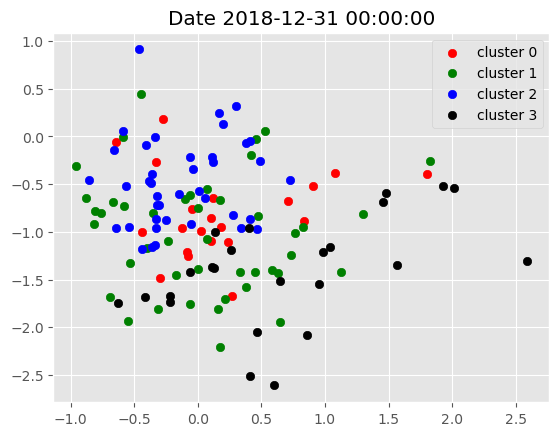

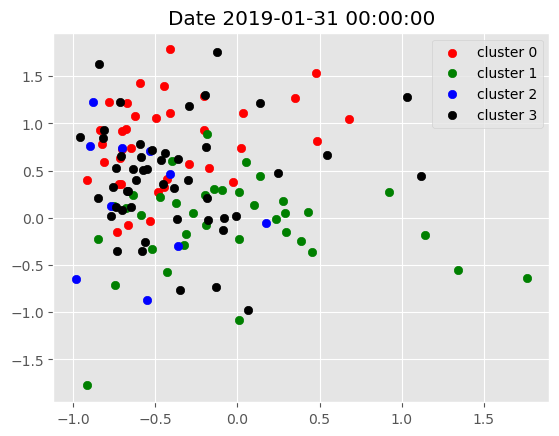

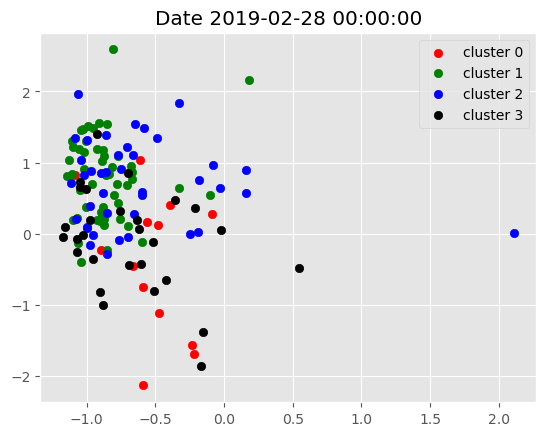

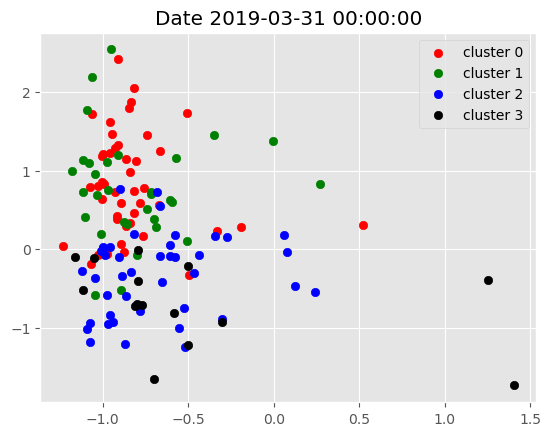

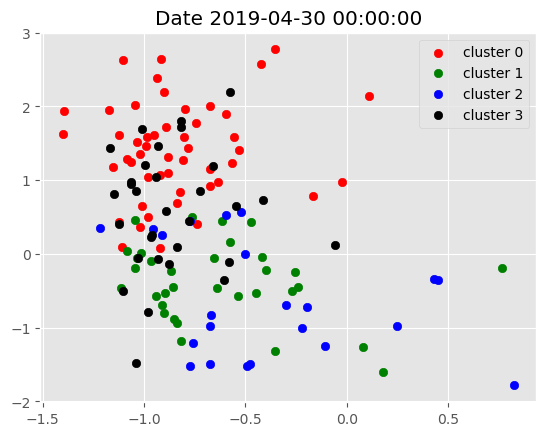

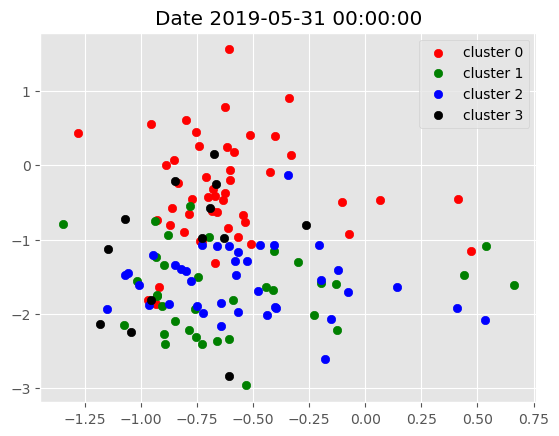

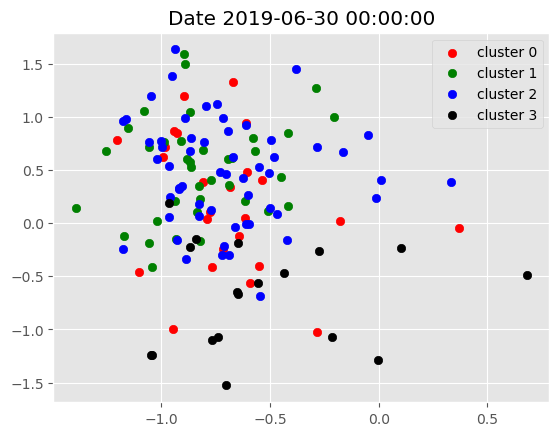

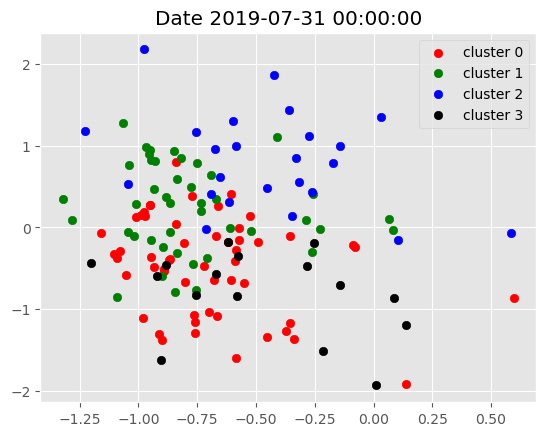

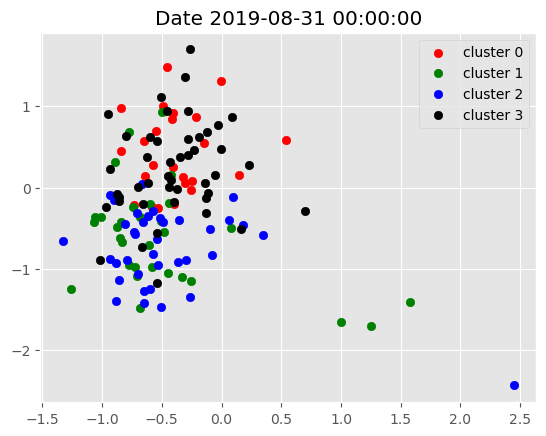

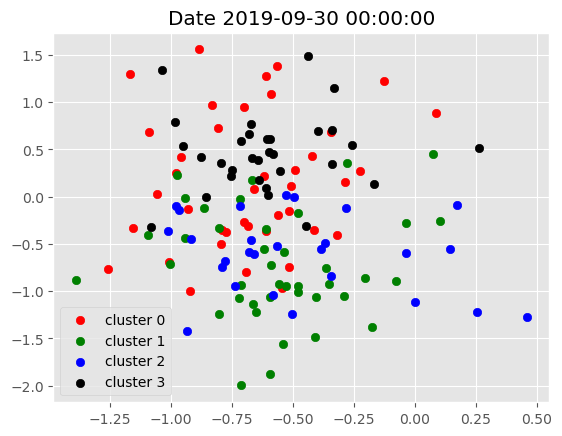

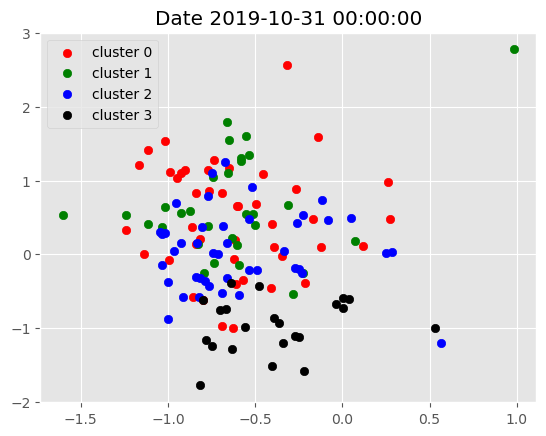

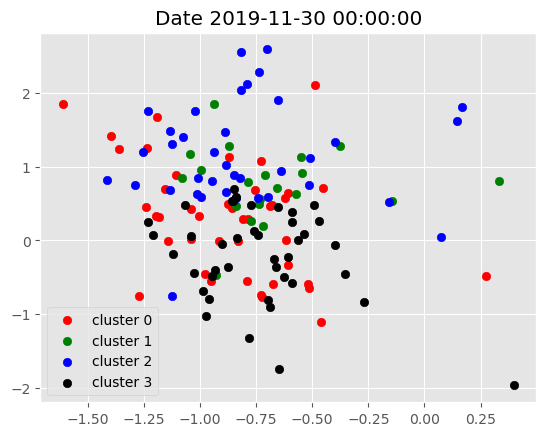

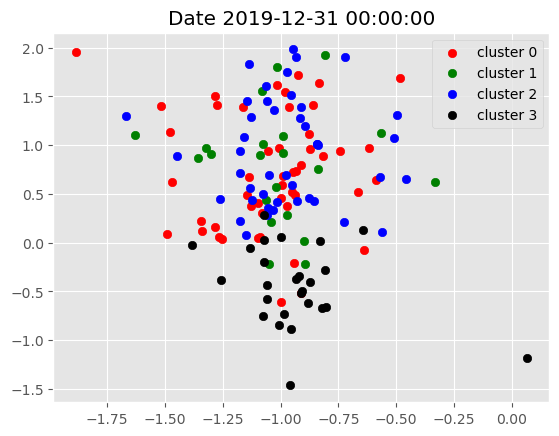

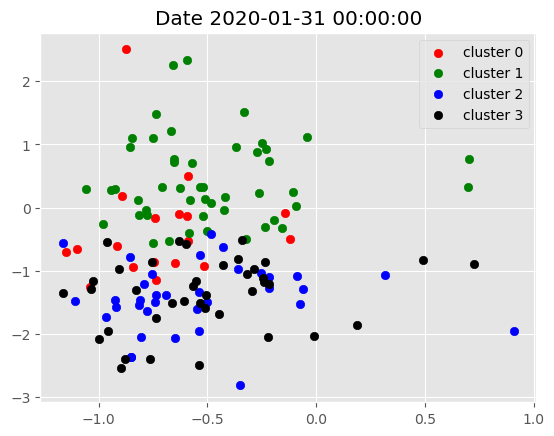

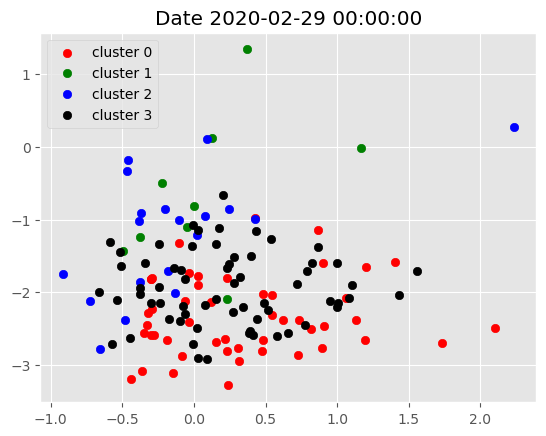

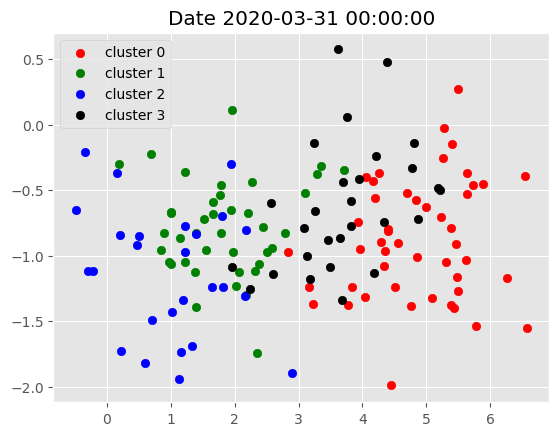

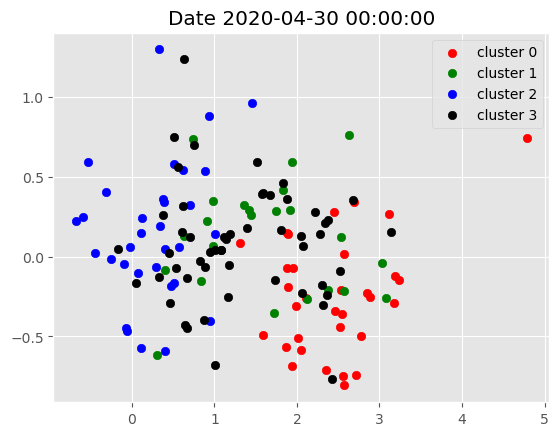

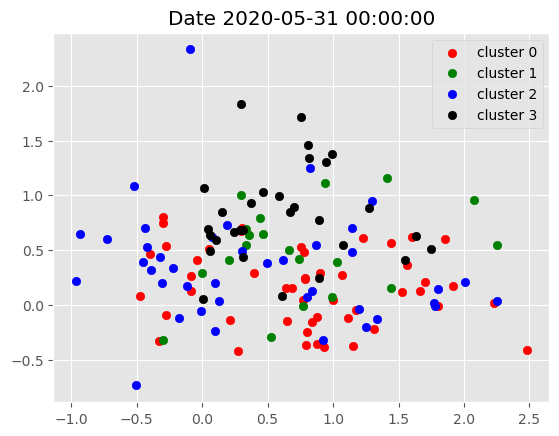

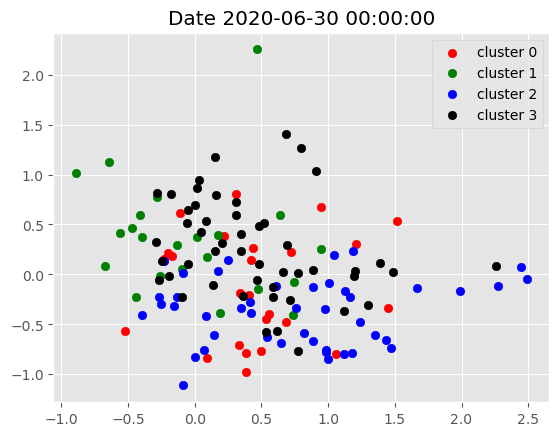

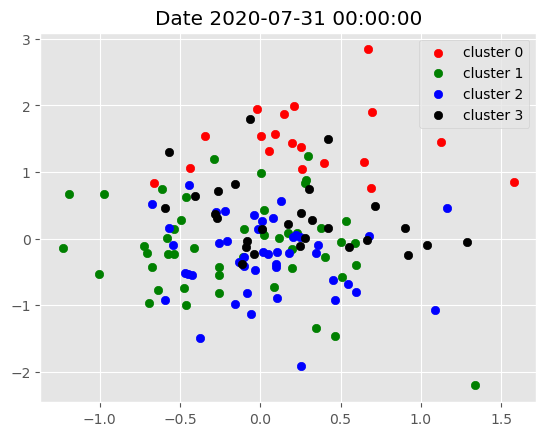

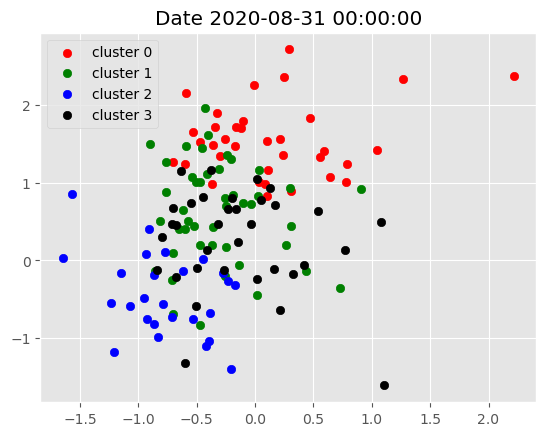

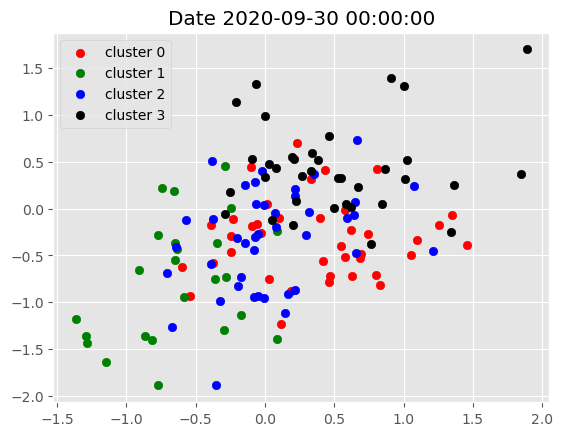

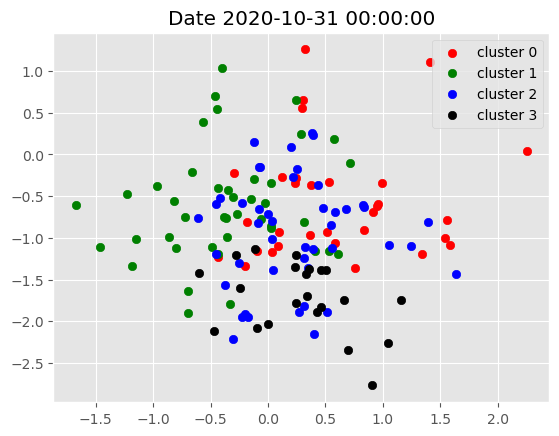

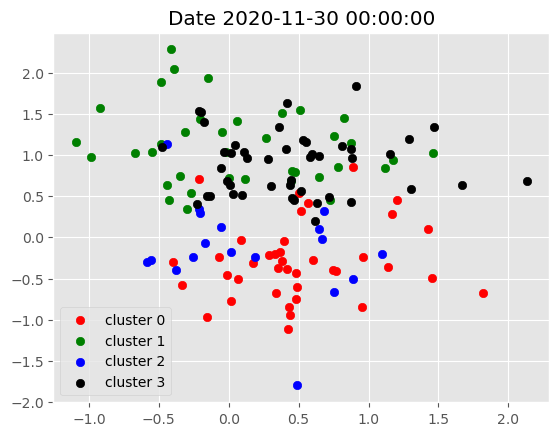

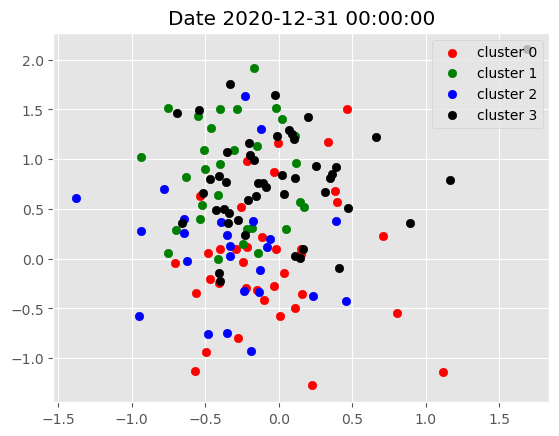

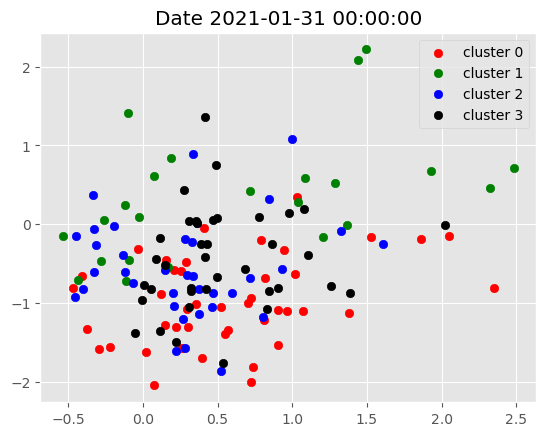

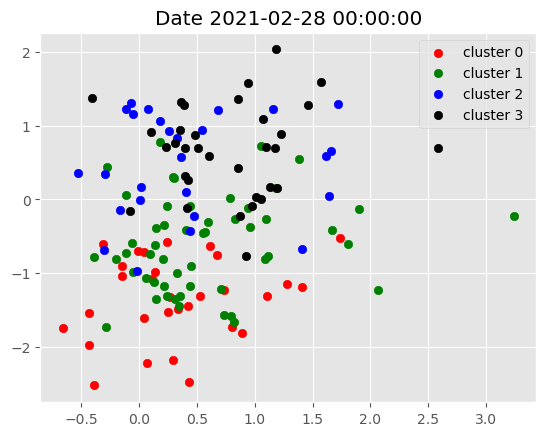

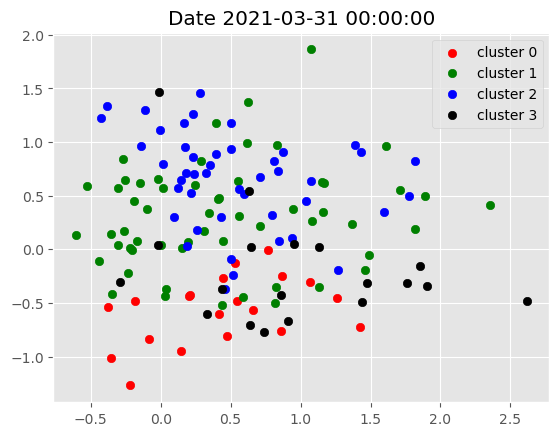

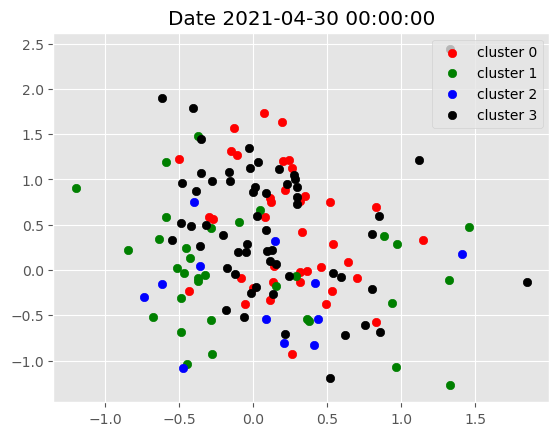

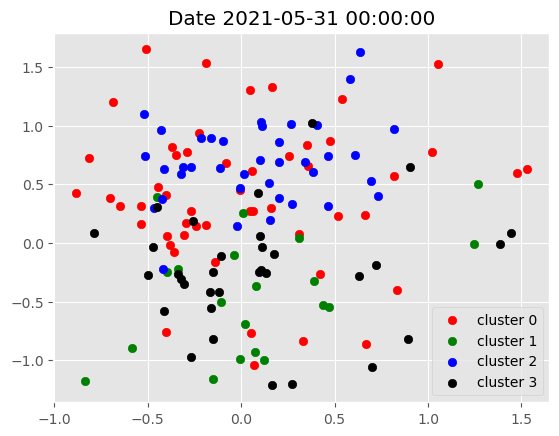

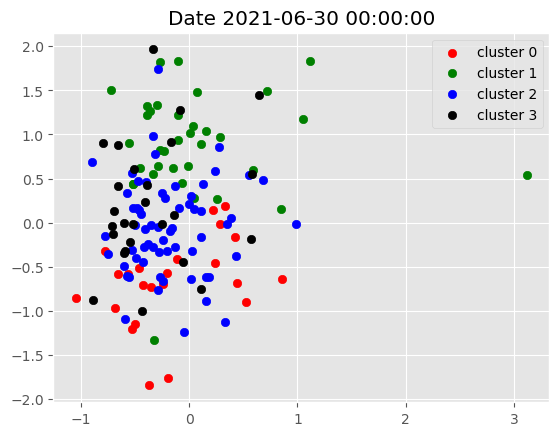

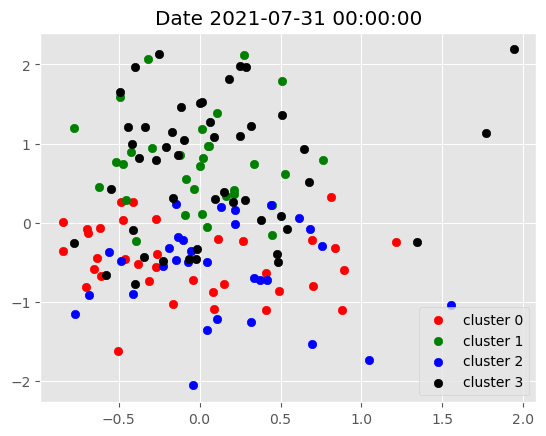

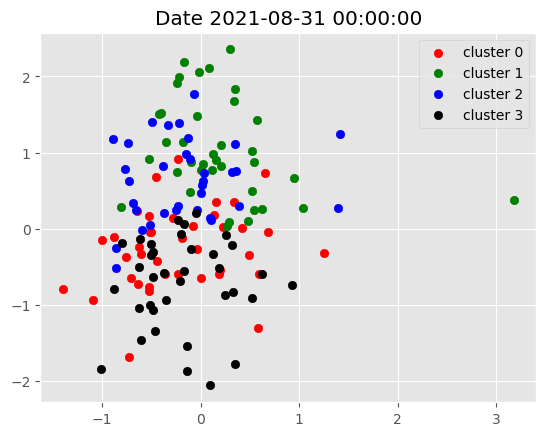

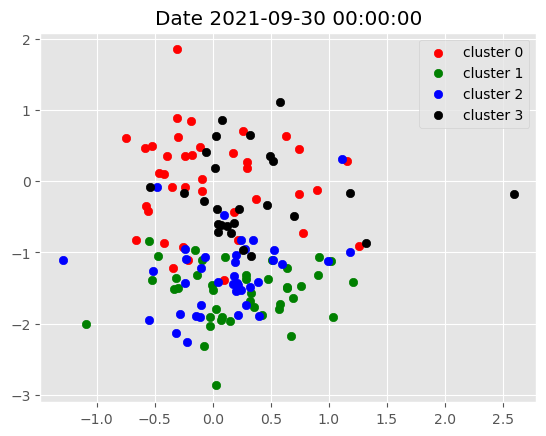

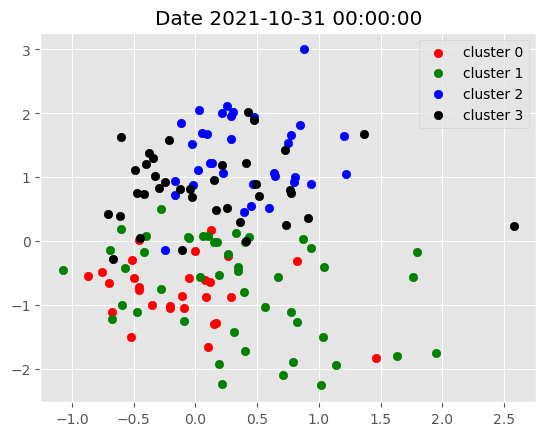

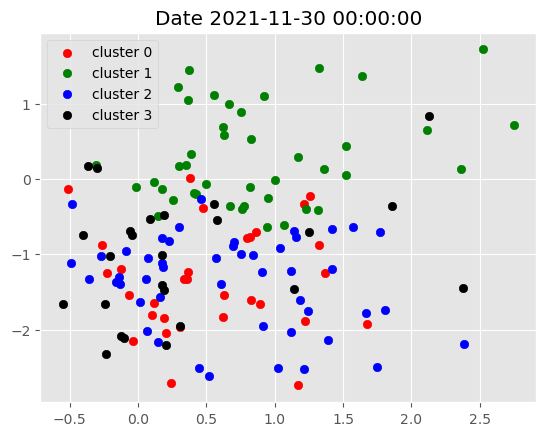

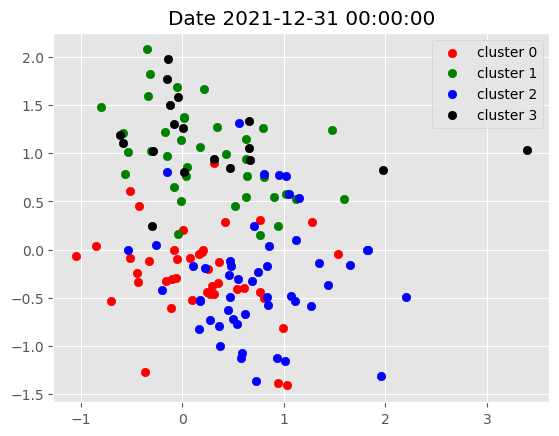

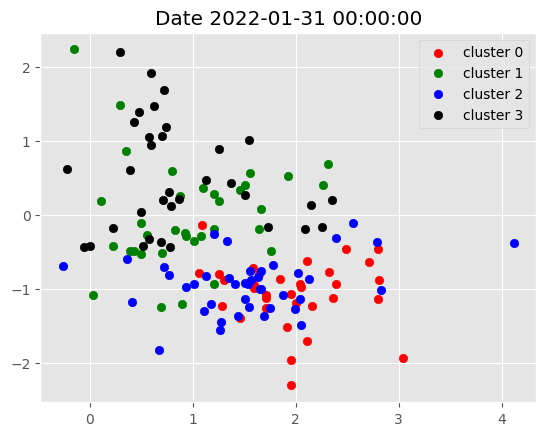

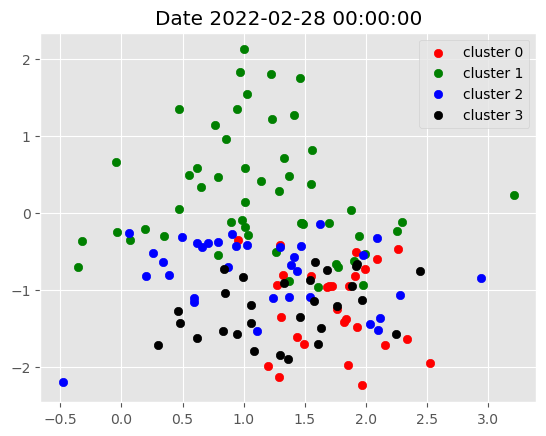

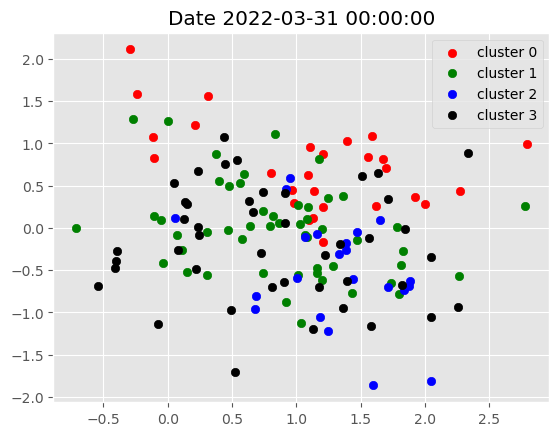

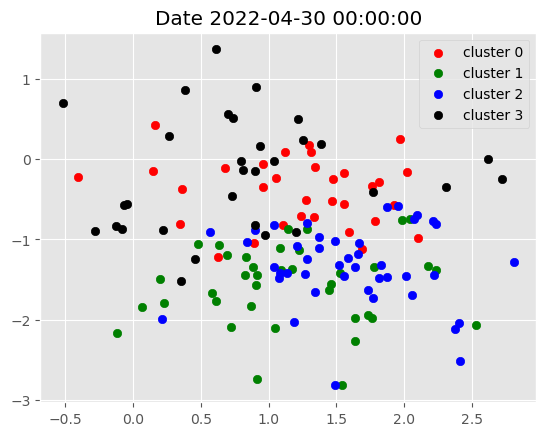

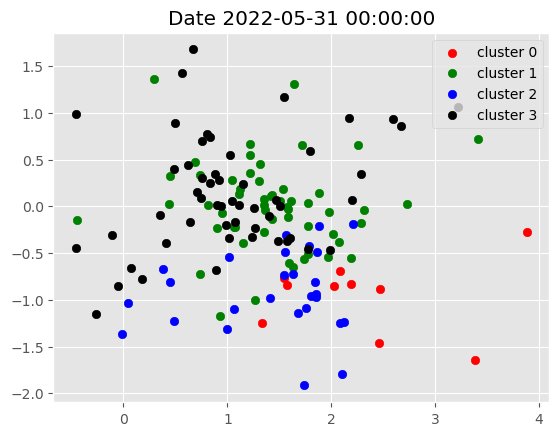

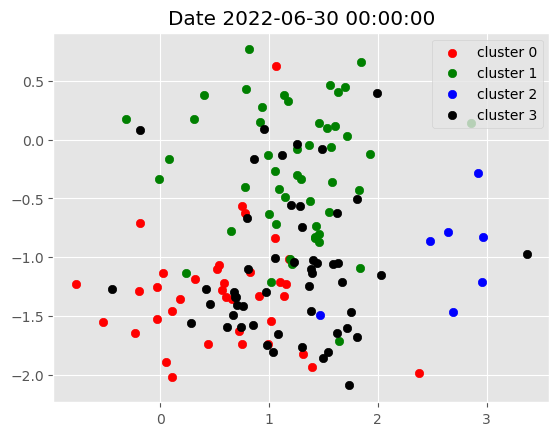

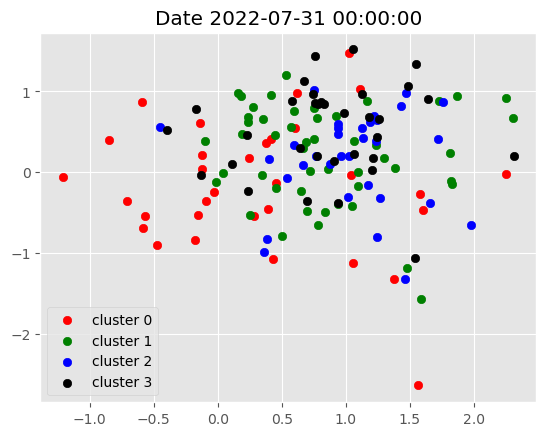

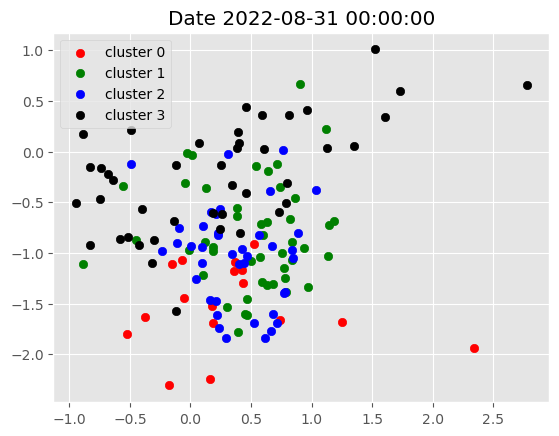

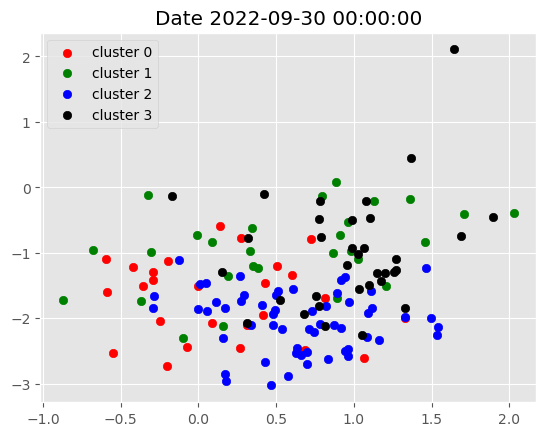

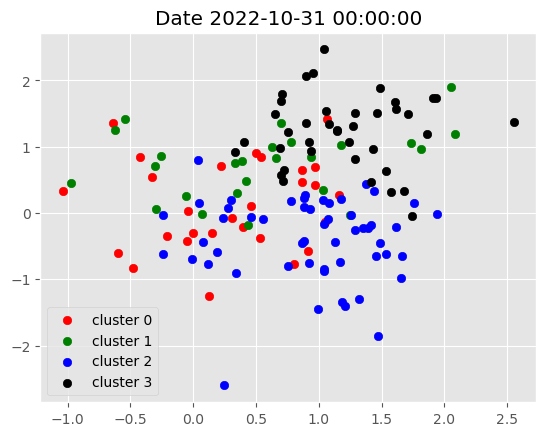

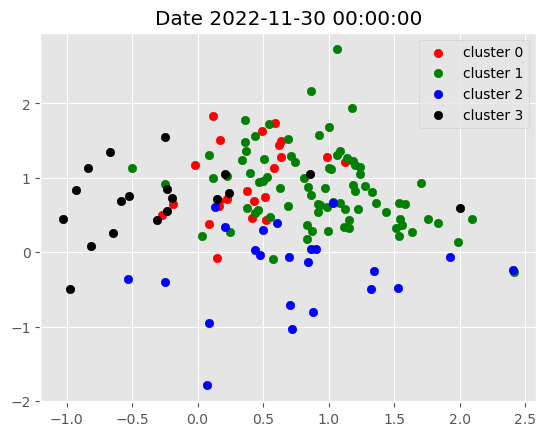

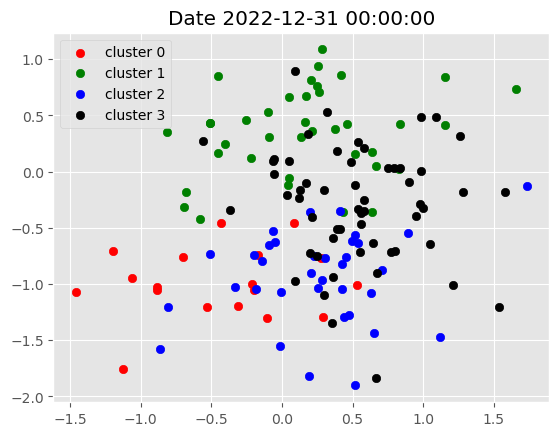

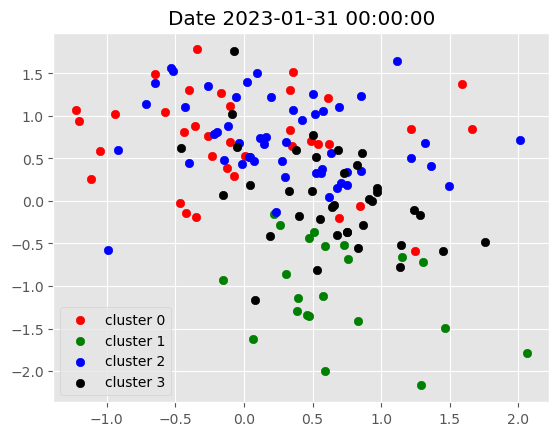

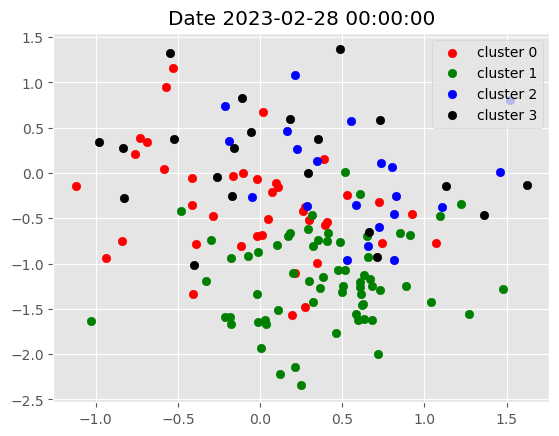

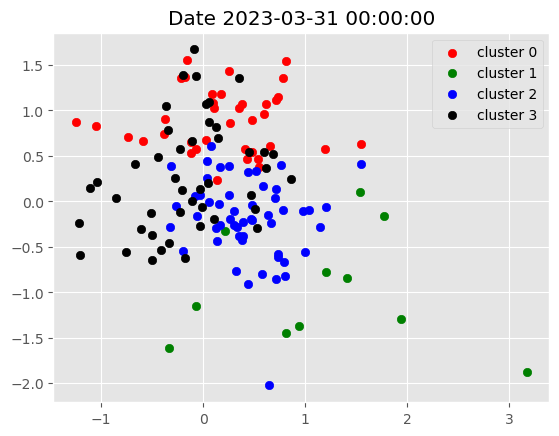

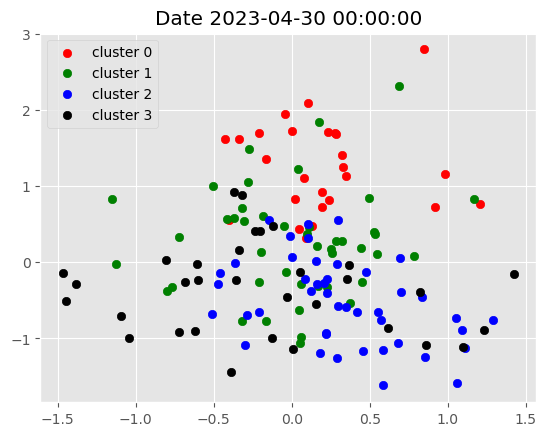

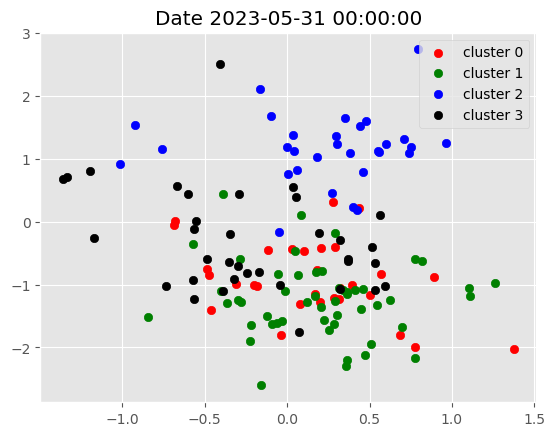

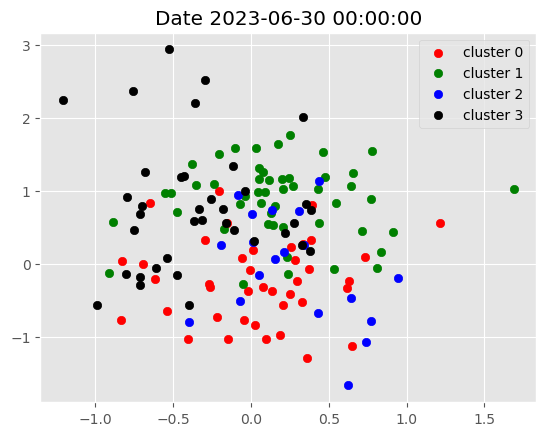

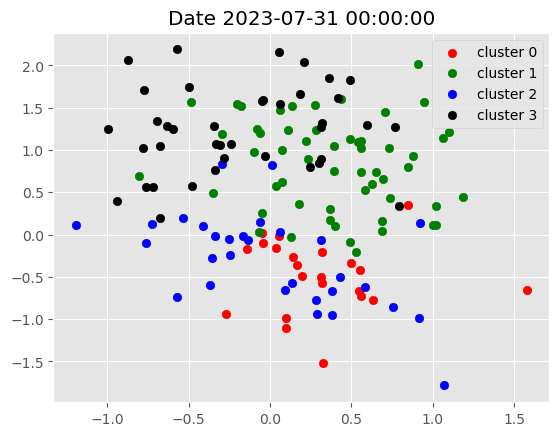

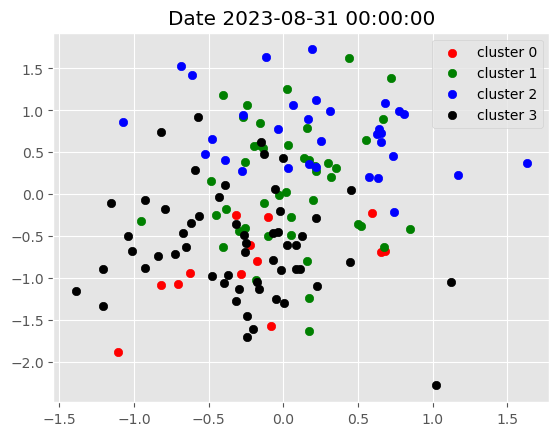

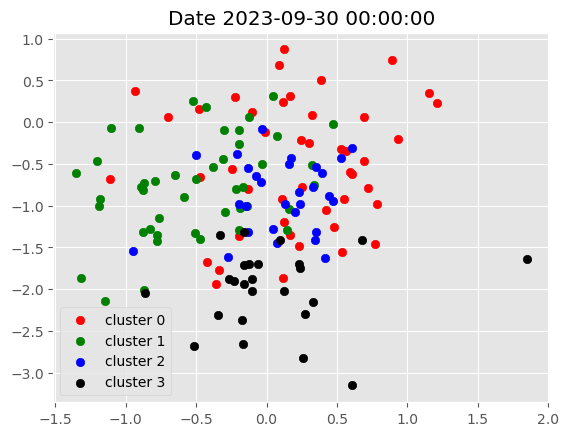

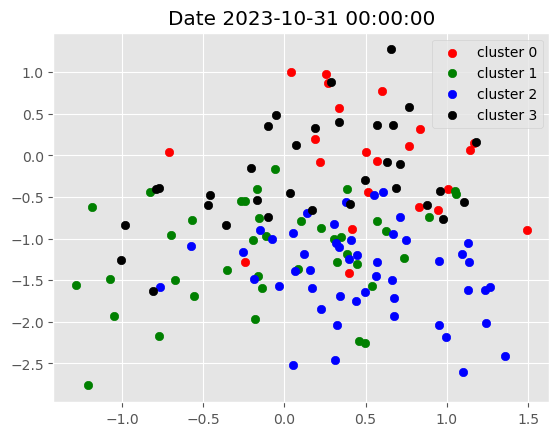

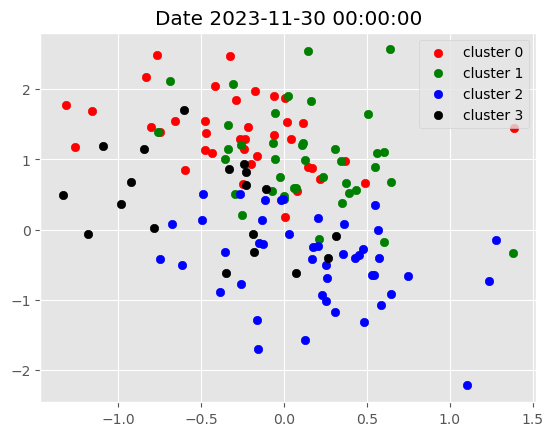

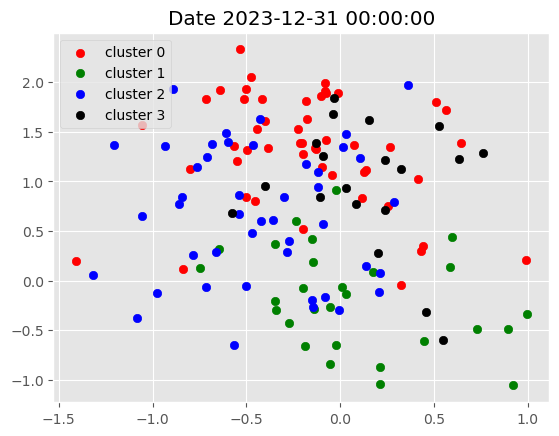

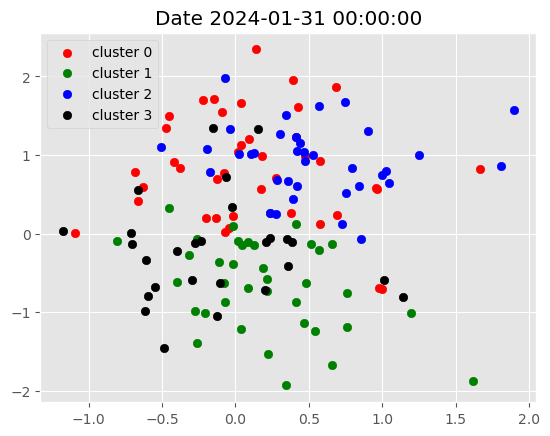

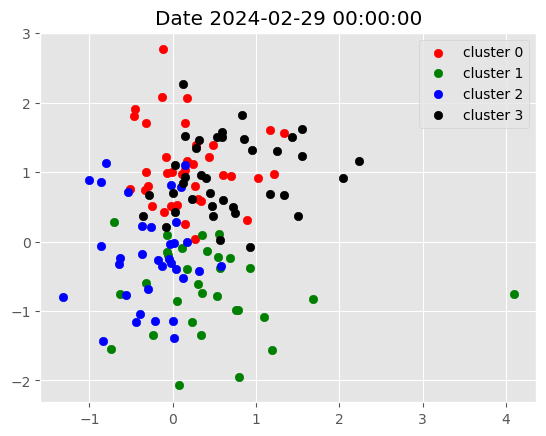

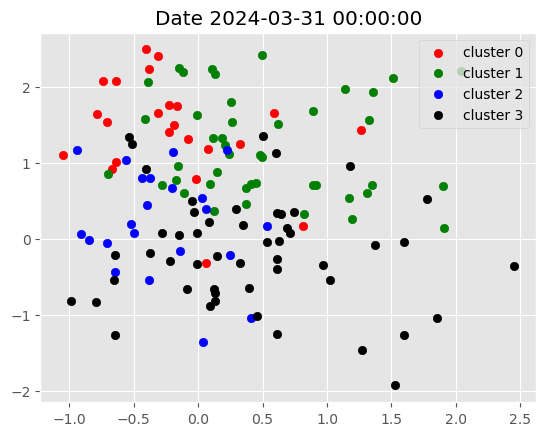

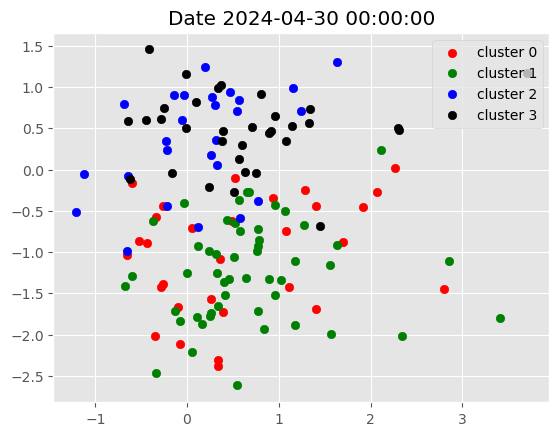

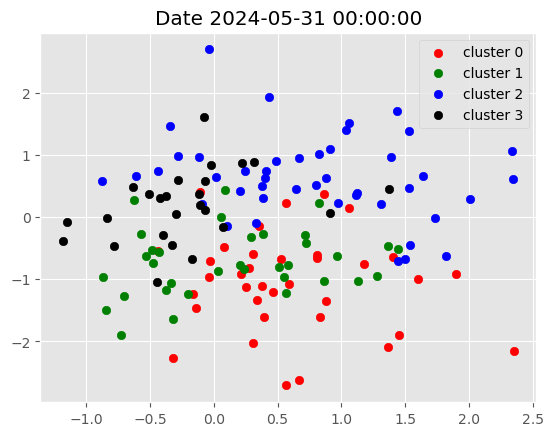

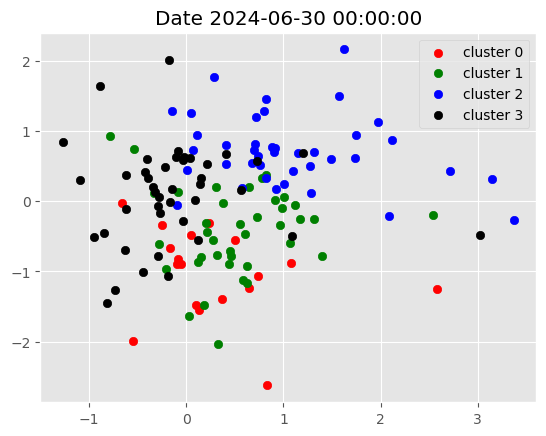

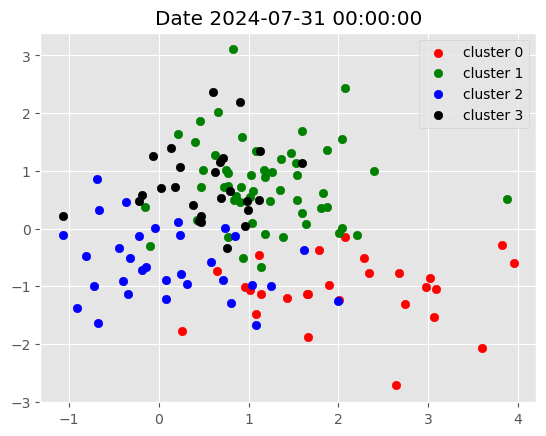

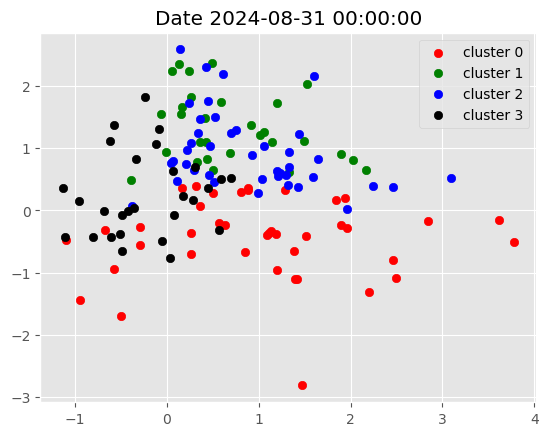

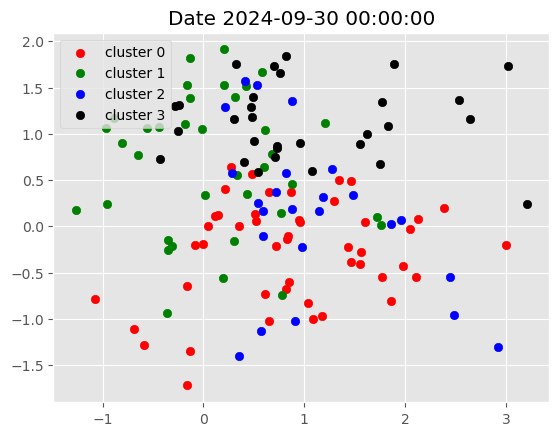

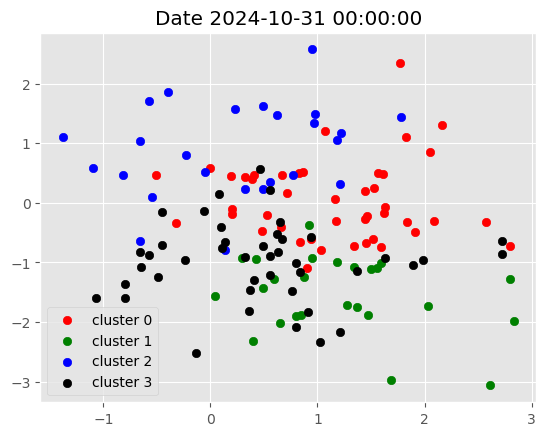

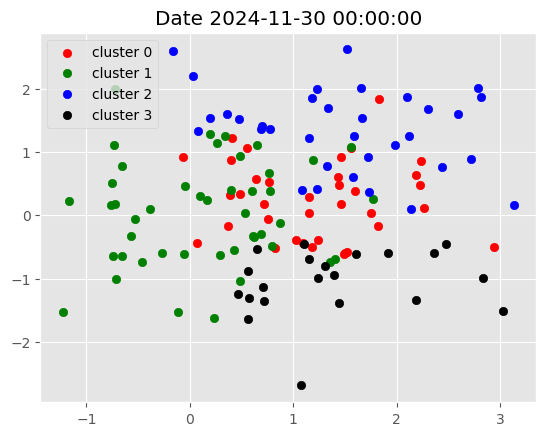

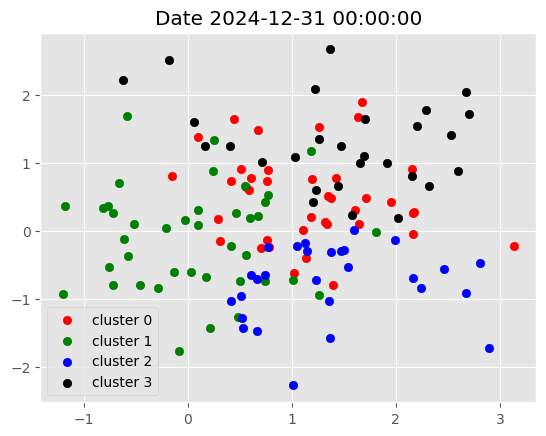

In [211]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [212]:
# For each month select assets based on cluster and form Portfolio using Efficient Frontier Max sharpe ratio optimization

filtered_df = data[data['cluster'] == 1].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates # we get stocks for next month

{'2019-01-01': ['AAPL',
  'AMAT',
  'AMD',
  'AVGO',
  'BAC',
  'BMY',
  'C',
  'CMCSA',
  'CMG',
  'COP',
  'CSCO',
  'CSX',
  'DAL',
  'EBAY',
  'F',
  'FCX',
  'GE',
  'GM',
  'HAL',
  'INTC',
  'KO',
  'LUV',
  'MDLZ',
  'MGM',
  'MO',
  'MS',
  'MU',
  'NEE',
  'NVDA',
  'ORCL',
  'OXY',
  'PANW',
  'PFE',
  'SCHW',
  'SLB',
  'T',
  'TJX',
  'TSLA',
  'USB',
  'VZ',
  'WDC',
  'WFC',
  'WMT',
  'XOM'],
 '2019-02-01': ['AAPL',
  'ABBV',
  'ABT',
  'AMZN',
  'BMY',
  'CMCSA',
  'CVS',
  'CVX',
  'DAL',
  'DD',
  'EA',
  'EOG',
  'GILD',
  'INTC',
  'JNJ',
  'KO',
  'LLY',
  'LOW',
  'MDT',
  'MO',
  'MRK',
  'MSFT',
  'NEE',
  'OXY',
  'PEP',
  'PFE',
  'PG',
  'PM',
  'PYPL',
  'QCOM',
  'RTX',
  'UAL',
  'UPS',
  'VZ',
  'WBA',
  'WMT',
  'XOM'],
 '2019-03-01': ['ACN',
  'ADBE',
  'ADI',
  'ADP',
  'ADSK',
  'AMT',
  'AXP',
  'BA',
  'BDX',
  'BLK',
  'CAT',
  'CHTR',
  'COST',
  'CRM',
  'CVX',
  'DE',
  'DHR',
  'DIS',
  'DLTR',
  'EXPE',
  'FDX',
  'GS',
  'HD',
  'HON',
  'IB

In [213]:
# Define portfolio optimization function - helps with diversification

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [215]:
# Get data from a year before the first date to compare returns

stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1] + pd.DateOffset(months=1))

new_df

[*********************100%***********************]  155 of 155 completed


Price            Close                                                  \
Ticker            AAPL        ABBV        ABNB         ABT         ACN   
Date                                                                     
2018-01-02   40.524345   71.669922         NaN   51.776558  138.659622   
2018-01-03   40.517277   72.791473         NaN   51.891056  139.299530   
2018-01-04   40.705486   72.376350         NaN   51.802986  140.948990   
2018-01-05   41.168938   73.636284         NaN   51.952713  142.111679   
2018-01-08   41.016029   72.456474         NaN   51.802986  143.247375   
...                ...         ...         ...         ...         ...   
2025-01-24  222.779999  170.300003  127.089996  125.029999  362.410004   
2025-01-27  229.860001  176.899994  128.960007  129.429993  373.149994   
2025-01-28  238.259995  174.809998  131.050003  127.389999  378.390015   
2025-01-29  239.360001  175.259995  132.580002  127.860001  374.420013   
2025-01-30  237.589996  175.649994  131.789993  128.809998  380.750000   

Price                                                                   ...  \
Ticker            ADBE         ADI         ADP        ADSK        ALGN  ...   
Date                                                                    ...   
2018-01-02  177.699997   79.129036  100.113724  107.120003  224.619995  ...   
2018-01-03  181.039993   80.110703  101.201256  109.379997  231.199997  ...   
2018-01-04  183.220001   80.023056  102.167953  112.070000  233.300003  ...   
2018-01-05  185.339996   80.347359  102.107544  110.839996  241.070007  ...   
2018-01-08  185.039993   80.487610  101.796837  111.419998  248.899994  ...   
...                ...         ...         ...         ...         ...  ...   
2025-01-24  435.380005  217.369995  297.100006  300.829987  233.300003  ...   
2025-01-27  438.600006  215.419998  300.149994  299.070007  229.820007  ...   
2025-01-28  442.839996  209.520004  298.309998  309.929993  226.169998  ...   
2025-01-29  441.679993  209.910004  300.570007  304.170013  224.449997  ...   
2025-01-30  446.000000  212.399994  303.260010  309.950012  225.360001  ...   

Price        Volume                                                            \
Ticker          VLO     VRTX        VZ       WBA     WDAY       WDC       WFC   
Date                                                                            
2018-01-02  3582900  1382000  16045300   6605000  1599600   3894000  13819300   
2018-01-03  3057600  1604000  16662400   7147300  2047900   3253300  14203700   
2018-01-04  2977000  1345100  12062800  12456000  2774000   5173100  18740500   
2018-01-05  2973800  1940000  13348900   9067200  1025400   2727400  14217900   
2018-01-08  2493400  1987000  16212700   5312500  1626600   4875300  15569400   
...             ...      ...       ...       ...      ...       ...       ...   
2025-01-24  2837300  1647800  37123900  12999000  1789100   6046500  10393200   
2025-01-27  2945700  1613600  35520300  36468400  2597700   7592100  10637100   
2025-01-28  2855400  1159600  21031900  19020700  2533000   7293300  11562000   
2025-01-29  2585800  1026500  24238100  16862800  1166500  10666600   9175400   
2025-01-30  3763400  1167300  27913500  17338000  1364500  16554200  11276000   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2018-01-02  30451500  2581200  11469300  
2018-01-03  26710800  3530900  13957700  
2018-01-04  20491200  2708800  10863000  
2018-01-05  21852000  2186600  11047600  
2018-01-08  26531700  1803800  10927100  
...              ...      ...       ...  
2025-01-24  14973800  1418400  14235900  
2025-01-27  18880600  2268100  15926700  
2025-01-28  14641600  1919200  15862000  
2025-01-29  11261400  1559800  12345500  
2025-01-30  11012200  2789700  14346300  

[1780 rows x 775 columns]

In [216]:
new_df.to_pickle("sp500_prices.pkl")

In [217]:
new_df = pd.read_pickle("sp500_prices.pkl")

In [218]:
returns_dataframe = np.log(new_df["Close"]).diff()

returns_dataframe

Ticker,AAPL,ABBV,ABNB,ABT,ACN,ADBE,ADI,ADP,ADSK,ALGN,...,VLO,VRTX,VZ,WBA,WDAY,WDC,WFC,WMT,WYNN,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,-0.000174,0.015528,NaN,0.002209,0.004604,0.018621,0.012330,0.010804,0.020878,0.028873,...,0.005266,-0.005903,-0.020763,0.007444,0.016973,0.015727,0.007664,0.008685,-0.010893,0.019450
2018-01-04,0.004634,-0.005719,NaN,-0.001699,0.011772,0.011970,-0.001095,0.009507,0.024296,0.009042,...,0.003210,0.006949,0.003237,-0.053170,0.038061,-0.006067,0.012430,0.000905,0.005400,0.001383
2018-01-05,0.011321,0.017258,NaN,0.002886,0.008215,0.011504,0.004044,-0.000591,-0.011036,0.032762,...,0.004690,0.016971,-0.002284,0.018268,0.000641,0.006308,0.006716,0.005910,0.006649,-0.000807
2018-01-08,-0.003721,-0.016152,NaN,-0.002886,0.007960,-0.001620,0.001744,-0.003048,0.005219,0.031964,...,0.002019,0.007678,-0.001716,0.012673,0.005655,-0.015232,-0.011379,0.014672,-0.013403,0.004486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-24,-0.003942,-0.002170,-0.047257,0.014582,-0.002343,-0.004354,-0.049279,0.004385,-0.000831,-0.006792,...,-0.007705,-0.000250,0.009146,0.011012,0.011605,-0.018665,-0.001422,0.010076,-0.001058,-0.013619
2025-01-27,0.031286,0.038023,0.014607,0.034586,0.029204,0.007369,-0.009011,0.010214,-0.005868,-0.015029,...,0.011960,0.009644,0.027440,-0.045678,0.022662,-0.045680,0.007987,0.027479,-0.002592,0.013801
2025-01-28,0.035892,-0.011885,0.016077,-0.015887,0.013945,0.009621,-0.027770,-0.006149,0.035669,-0.016010,...,-0.022761,-0.007235,-0.005923,-0.040491,0.023307,-0.024045,-0.000770,-0.001130,-0.005204,-0.019523


In [219]:
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    try:
        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        if (start_date >= end_date):
            break
        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        while optimization_end_date not in new_df.index:
            optimization_end_date = (pd.to_datetime(optimization_end_date) - pd.DateOffset(days = 1)).strftime("%Y-%m-%d")

        while optimization_start_date not in new_df.index:
            optimization_start_date = (pd.to_datetime(optimization_start_date) + pd.DateOffset(days = 1)).strftime("%Y-%m-%d")

        optimization_df = new_df.loc[optimization_start_date : optimization_end_date]["Close"][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1 / len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index = optimization_df.columns.tolist(),
                                     columns = pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date: end_date]

        temp_df = temp_df = temp_df.stack().to_frame("return").reset_index(level=0)\
                   .merge(weights.stack().to_frame("weight").reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .rename_axis(None).reset_index().set_index(["Date", "index"]).unstack().stack()
        temp_df.index.names = ["date", "ticker"]

        temp_df["weighted_return"] = temp_df["return"]*temp_df["weight"]

        temp_df = temp_df.groupby(level=0)["weighted_return"].sum().to_frame("Strategy Return")

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print("Error", e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-04-01, Continuing with Equal-Weights


,Strategy Return
date,
2019-01-02,0.003441
2019-01-03,-0.029181
2019-01-04,0.038681
2019-01-07,0.024133
2019-01-08,0.009170
...,...
2025-01-24,-0.002896
2025-01-27,0.019416
2025-01-28,-0.002833


## Compare with historical S&P 500 index

In [220]:
spy = yf.download(tickers='SPY',
                  start='2019-01-01',
                  end=dt.date.today())
spy

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2019-01-02,227.637512,228.574717,223.788660,223.815956,126925200
2019-01-03,222.205399,226.172540,221.714048,225.863165,144140700
2019-01-04,229.648361,230.303487,224.898709,225.280863,142628800
2019-01-07,231.459030,232.887558,229.011411,229.921306,103139100
2019-01-08,233.633728,234.125079,231.113329,233.679239,102512600
...,...,...,...,...,...
2025-01-31,601.820007,609.960022,601.049988,607.500000,66671500
2025-02-03,597.770020,600.289978,590.489990,592.669983,65857200


In [221]:
spy.to_pickle("sp500_index_returns.pkl")

In [222]:
spy = pd.read_pickle("sp500_index_returns.pkl")

In [223]:
spy_ret = np.log(spy[['Close']]).diff().dropna()
spy_ret = spy_ret.droplevel([1], axis=1) 
spy_ret.columns = ["SPY Buy&Hold"]

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df 

,Strategy Return,SPY Buy&Hold
2019-01-03,-0.029181,-0.024152
2019-01-04,0.038681,0.032947
2019-01-07,0.024133,0.007854
2019-01-08,0.009170,0.009352
2019-01-09,0.003458,0.004662
...,...,...
2025-01-24,-0.002896,-0.002924
2025-01-27,0.019416,-0.014246
2025-01-28,-0.002833,0.008556
2025-01-29,-0.001503,-0.004493


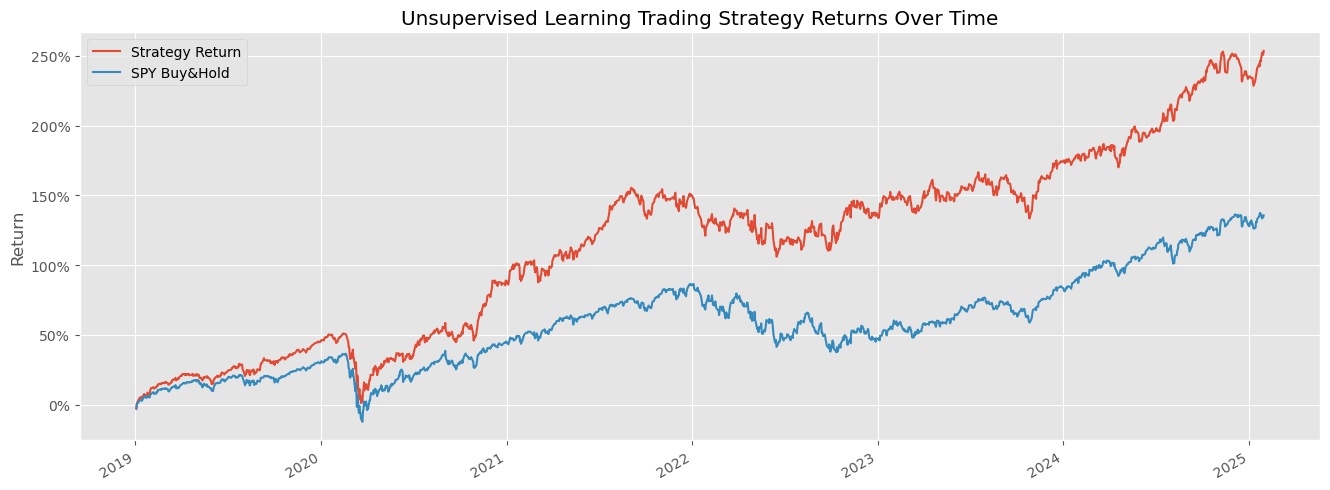

In [224]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2025-01-31'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

## Looks like we beat the market! Hurray!